# Preprocessing for complex PDF

## Setting
 - Auto Reload
 - path for utils

In [2]:
import os
os.environ['AWS_DEFAULT_REGION'] = 'us-west-2'

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import sys, os

def add_python_path(module_path):
    if os.path.abspath(module_path) not in sys.path:
        sys.path.append(os.path.abspath(module_path))
        print(f"python path: {os.path.abspath(module_path)} is added")
    else:
        print(f"python path: {os.path.abspath(module_path)} already exists")
    print("sys.path: ", sys.path)

module_path = "../../.."
add_python_path(module_path)

python path: /home/ubuntu/projects/aws-ai-ml-workshop-kr/genai/aws-gen-ai-kr/20_applications/08_bedrock_manus/use_cases/04_basic_agent_frame is added
sys.path:  ['/home/ubuntu/.local/share/uv/python/cpython-3.12.11-linux-aarch64-gnu/lib/python312.zip', '/home/ubuntu/.local/share/uv/python/cpython-3.12.11-linux-aarch64-gnu/lib/python3.12', '/home/ubuntu/.local/share/uv/python/cpython-3.12.11-linux-aarch64-gnu/lib/python3.12/lib-dynload', '', '/home/ubuntu/projects/aws-ai-ml-workshop-kr/genai/aws-gen-ai-kr/20_applications/08_bedrock_manus/use_cases/04_basic_agent_frame/setup/.venv/lib/python3.12/site-packages', '/home/ubuntu/projects/aws-ai-ml-workshop-kr/genai/aws-gen-ai-kr/20_applications/08_bedrock_manus/use_cases/04_basic_agent_frame']


## 1. Create Bedrock client
Amazon Bedrock을 API로 활용하기 위한 Client를 설정합니다. 

In [5]:
from pprint import pprint
from termcolor import colored
from src.utils import bedrock
from src.utils.bedrock import bedrock_info

### ---- ⚠️ Un-comment and edit the below lines as needed for your AWS setup ⚠️ ----
- os.environ["AWS_DEFAULT_REGION"] = "<REGION_NAME>"  # E.g. "us-east-1"
- os.environ["AWS_PROFILE"] = "<YOUR_PROFILE>"
- os.environ["BEDROCK_ASSUME_ROLE"] = "<YOUR_ROLE_ARN>"  # E.g. "arn:aws:..."
- os.environ["BEDROCK_ENDPOINT_URL"] = "<YOUR_ENDPOINT_URL>"  # E.g. "https://..."

In [6]:
boto3_bedrock = bedrock.get_bedrock_client(
    assumed_role=os.environ.get("BEDROCK_ASSUME_ROLE", None),
    endpoint_url=os.environ.get("BEDROCK_ENDPOINT_URL", None),
    region=os.environ.get("AWS_DEFAULT_REGION", None),
)

print (colored("\n== FM lists ==", "green"))
pprint (bedrock_info.get_list_fm_models(verbose=False))

boto3 Bedrock client successfully created!
bedrock-runtime(https://bedrock-runtime.us-west-2.amazonaws.com)

== FM lists ==
{'Claude-Instant-V1': 'anthropic.claude-instant-v1',
 'Claude-V1': 'anthropic.claude-v1',
 'Claude-V2': 'anthropic.claude-v2',
 'Claude-V2-1': 'anthropic.claude-v2:1',
 'Claude-V3-5-Sonnet': 'anthropic.claude-3-5-sonnet-20240620-v1:0',
 'Claude-V3-5-V-2-Sonnet': 'anthropic.claude-3-5-sonnet-20241022-v2:0',
 'Claude-V3-5-V-2-Sonnet-CRI': 'us.anthropic.claude-3-5-sonnet-20241022-v2:0',
 'Claude-V3-7-Sonnet-CRI': 'us.anthropic.claude-3-7-sonnet-20250219-v1:0',
 'Claude-V3-Haiku': 'anthropic.claude-3-haiku-20240307-v1:0',
 'Claude-V3-Opus': 'anthropic.claude-3-sonnet-20240229-v1:0',
 'Claude-V3-Sonnet': 'anthropic.claude-3-sonnet-20240229-v1:0',
 'Claude-V4-1-Opus-CRI': 'us.anthropic.claude-opus-4-1-20250805-v1:0',
 'Claude-V4-Opus-CRI': 'us.anthropic.claude-opus-4-20250514-v1:0',
 'Claude-V4-Sonnet-CRI': 'us.anthropic.claude-sonnet-4-20250514-v1:0',
 'Cohere-Embeddin

## 2. Titan Embedding v2 및 LLM 인 Claude-v3-sonnet 모델 로딩

### LLM 로딩 (Claude-v3-sonnet)

In [8]:
from langchain_aws import ChatBedrock
from langchain_core.callbacks.streaming_stdout import StreamingStdOutCallbackHandler

In [9]:
llm_text = ChatBedrock(
    model_id=bedrock_info.get_model_id(model_name="Claude-V4-Sonnet-CRI"),
    client=boto3_bedrock,
    streaming=True,
    callbacks=[StreamingStdOutCallbackHandler()],
    model_kwargs={
        "max_tokens": 8192,
        "stop_sequences": ["\n\nHuman"],
        # "temperature": 0,
        # "top_k": 350,
        # "top_p": 0.999
    }
)
llm_text

ChatBedrock(callbacks=[<langchain_core.callbacks.streaming_stdout.StreamingStdOutCallbackHandler object at 0xe67e9c476300>], client=<botocore.client.BedrockRuntime object at 0xe67e9ea9a8a0>, bedrock_client=<botocore.client.Bedrock object at 0xe67e9c373f50>, model_id='us.anthropic.claude-sonnet-4-20250514-v1:0', model_kwargs={'stop_sequences': ['\n\nHuman']}, streaming=True, max_tokens=8192)

### Embedding 모델 선택

In [10]:
from langchain_aws import BedrockEmbeddings

In [11]:
llm_emb = BedrockEmbeddings(
    client=boto3_bedrock,
    model_id=bedrock_info.get_model_id(model_name="Titan-Text-Embeddings-V2")
)
dimension = 1024
print("Bedrock Embeddings Model Loaded")

Bedrock Embeddings Model Loaded


## 3. 데이터 준비 

### Extract Text, Table and Image from documents

### 3.1 Upstage Document Parse
- ### Prerequisites
    - #### 해당 에셋은 complex document parsing을 위해 [Upstage Document Parse](https://aws.amazon.com/marketplace/pp/prodview-lv5bnpdco7xoq?sr=0-4&ref_=beagle&applicationId=AWSMPContessa)을 이용합니다. 
    - Upstage Document Parse는 AWS Marketplace에 등록되어 있으며, Amazon SageMaker Endpoint 생성을 통해 사용하실 수 있습니다.
        - Endpoint 생성 방식은 **["05_1_create_endpoint_upstage_document_parse.ipynb"](./05_1_create_endpoint_upstage_document_parse.ipynb)** 참고하시기 바랍니다.
- ### **[API Description](https://developers.upstage.ai/docs/apis/document-parse)**


In [12]:
import shutil

import math
import base64
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
from pdf2image import convert_from_path

from src.utils.common_utils import to_pickle, load_pickle
from langchain_core.documents import Document

**엔드포인트 이름을 입력합니다.**
- Endpoint 생성 방식은 **["05_1_create_endpoint_upstage_document_parse.ipynb"](./05_1_create_endpoint_upstage_document_parse.ipynb)** 참고하시기 바랍니다.

In [13]:
endpoint_document_parser = "<your endpont>"
endpoint_document_parser = "Upstage-Document-Parse-Test-2025-10-25-08-18-31-168"

**추출할 문서의 위치를 입력합니다.**

In [14]:
file_path = "../data/sample.pdf"

**추출된 이미지가 저장될 위치를 입력합니다.**

In [15]:
image_path = "./fig"

**문서 파싱을 시작합니다 (약 1분 소요)**

In [21]:
import json
import boto3
from requests_toolbelt import MultipartEncoder

In [22]:
%%time

if os.path.isdir(image_path): shutil.rmtree(image_path)
os.mkdir(image_path)

runtime_sm_client = boto3.client('runtime.sagemaker')

# Prepare multipart form data
encoder = MultipartEncoder(
    fields={
        'document': (os.path.basename(file_path), open(file_path, 'rb'), 'application/pdf'),
        'model': 'document-parse',
        'ocr': 'auto',
        'coordinates': 'true',
        'output_formats': '["markdown"]', #'["text", "html", "markdown"]',
        'base64_encoding': '["table", "figure"]',
        'chart_recognition': 'false',
    }
)

# Get the raw bytes of the multipart form data
body = encoder.to_string()

response = runtime_sm_client.invoke_endpoint(
    EndpointName=endpoint_document_parser,
    ContentType=encoder.content_type,  # This will be 'multipart/form-data; boundary=...'
    Body=body
)

result = response["Body"].read()
parse_output = json.loads(result)

CPU times: user 46.4 ms, sys: 2.06 ms, total: 48.5 ms
Wall time: 1.68 s


In [23]:
to_pickle(parse_output, "sample.pkl")

To_PICKLE: sample.pkl


In [24]:
parse_output = load_pickle("sample.pkl")

Load from sample.pkl


In [25]:
parse_output.keys()

dict_keys(['api', 'content', 'elements', 'merged_elements', 'model', 'ocr', 'usage'])

In [26]:
parse_output["content"]

{'html': '',
 'markdown': '핵 심 설 명 서\n\n이 설명서는 금융소비자의 권익 보호 및 금융상품에 대한 이해 증진을 위하여\n금융상품의 핵심내용을 쉽게 이해하실 수 있도록 작성한 것입니다. 상품내용을\n충분히 이해하신 다음에 청약여부를 결정하시기 바랍니다.\n\n# 핵심설명서\n\n# [미래에셋증권 제 253 회 파생결합증권(DLS)(원금보장형)]\n\n# 1\n\n# 상품 개요\n\n- ○ 모집가액: 100 억원 (모집된 금액이 10 억 미만일 경우 발행이 취소될 수 있음)\n- ○ 기초자산: KOSPI200 지수(블룸버그 Ticker: KOSPI2 index),\n- 금가격지수 (블룸버그 Ticker: GOLDLNPM index)\n- ○ 청약기간 : 2011 년 07 월 04 일 ~2011 년 07 월 07 일 16 시\n- ○ 청약단위 : 100 만원 이상 100 만원 단위 (발행 후 추가 납입 불가)\n- ○ 발 행 일 : 2011 년 07 월 08 일\n- ○ 만 기 일 : 2012 년 07 월 09 일(만기 1 년)\n- ○ 상품위험등급: 4 등급\n\n\n# 2\n\n# 기준가격 결정일 및 평가방법\n\n- ○ 최초 기준가격: 2011 년 07 월 07 일의 종가(해당 거래소 기준)\n- ○ 만기 평가가격: 2012 년 07 월 03 일의 종가(해당 거래소 기준)\n\n\n# 3 손익 구조\n\n| 구 분 | 내 용 | 만기상환금액 |\n| --- | --- | --- |\n| 만기 상환 | ① 만기평가가격이 최초기준가격의 100% 이상인 경우 (만기수 익률이 낮은 기초자산 기준) | 총액면금액×[100%+{(만기평가가격-최초 기준가격) /최초기준가격 × 70%}] |\n| 만기 상환 | ② 만기평가가격이 최초기준가격의 100% 미만인 경우 (만기수 익률이 낮은 기초자산 기준) | 총액면금액×100% |\n\n\n※ 만기수익률=(만기평가가격-최초기준가격)/최초기준가격\n(단, {(만기평가가격-최초기준가격)/최초기준가격×70

In [27]:
parse_output["elements"][1]#.keys()

{'category': 'paragraph',
 'content': {'html': '',
  'markdown': '이 설명서는 금융소비자의 권익 보호 및 금융상품에 대한 이해 증진을 위하여\n금융상품의 핵심내용을 쉽게 이해하실 수 있도록 작성한 것입니다. 상품내용을\n충분히 이해하신 다음에 청약여부를 결정하시기 바랍니다.',
  'text': ''},
 'coordinates': [{'x': 0.2009, 'y': 0.0173},
  {'x': 0.9314, 'y': 0.0173},
  {'x': 0.9314, 'y': 0.0702},
  {'x': 0.2009, 'y': 0.0702}],
 'id': 1,
 'page': 1}

**문서 파싱 후처리를 합니다.**
- docs: 문서는 페이지별 정리
- texts: markdown 형식의 전체 texts

In [28]:
def postprocessing(**kwargs):
    
    category = kwargs["category"]
    markdown = kwargs["markdown"]
    base64_encoding = kwargs["base64_encoding"]
    coordinates = kwargs["coordinates"]
    page = kwargs["page"]
    docs = kwargs["docs"]
    
    if page in docs: 
        docs[page].append({"category": category, "markdown": markdown, "base64_encoding": base64_encoding, "coordinates": coordinates})
    else:
        docs[page] = [{"category": category, "markdown": markdown, "base64_encoding": base64_encoding, "coordinates": coordinates}]
        
    return docs

def extract_image_table(**kwargs):
    
    image_path = kwargs["image_path"]
    file_path = kwargs["file_path"]
    
    image_tmp_path = os.path.join(image_path, "tmp")
    if os.path.isdir(image_tmp_path): shutil.rmtree(image_tmp_path)
    os.mkdir(image_tmp_path)

    # from pdf to image
    pages = convert_from_path(file_path)
    for i, page in enumerate(pages):
        print (f'pdf page {i}, size: {page.size}')    
        page.save(f'{image_tmp_path}/{str(i+1)}.jpg', "JPEG")
        
    return image_tmp_path

pdf page 0, size: (1654, 2339)
pdf page 1, size: (1654, 2339)
pdf page 2, size: (1654, 2339)


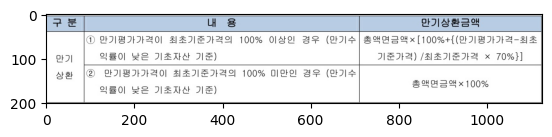

page_number: 1
==
image: ./fig/element-11.jpg, shape: (1501, 270), image_token_for_claude3: 540.36


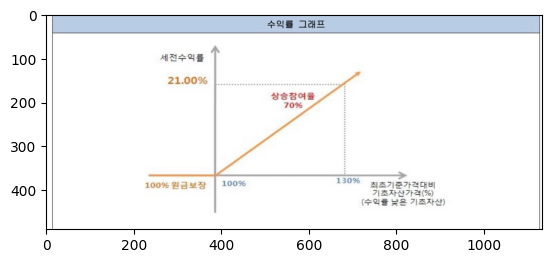

page_number: 3
==
image: ./fig/element-42.jpg, shape: (1511, 653), image_token_for_claude3: 1315.5773333333334


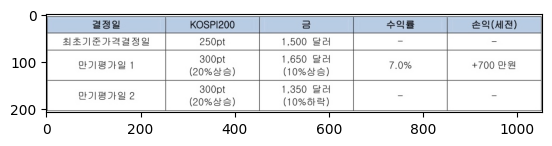

page_number: 3
==
image: ./fig/element-45.jpg, shape: (1402, 278), image_token_for_claude3: 519.6746666666667


In [29]:
docs = {}
texts = [
    Document(
        page_content=parse_output["content"]["markdown"]
    )
]

## extract_image_table
image_tmp_path = extract_image_table(
    image_path=image_path,
    file_path=file_path
)

for idx, value in enumerate(parse_output["elements"]):
      
    category = value["category"]
    markdown = value["content"]["markdown"]
    page = value["page"]
    
    if category in ["figure", "table"]:
        
        base64_encoding = value["base64_encoding"]    
        coordinates = value["coordinates"]    
        img = Image.open(BytesIO(base64.b64decode(base64_encoding)))
        plt.imshow(img)
        plt.show()
        
        # PIL로 이미지 로드
        page_img = Image.open(f'{image_tmp_path}/{page}.jpg')
        w, h = page_img.size  # PIL은 (width, height) 순서
        
        # 좌표 계산
        left = math.ceil(coordinates[0]["x"] * w)
        top = math.ceil(coordinates[0]["y"] * h)
        right = math.ceil(coordinates[1]["x"] * w)
        bottom = math.ceil(coordinates[3]["y"] * h)
        
        # PIL로 이미지 크롭
        crop_img = page_img.crop((left, top, right, bottom))
                
        crob_image_path = f'{image_path}/element-{idx}.jpg'
        crop_img.save(crob_image_path)

        print (f'page_number: {page}')
        print ("==")

        w_crop, h_crop = crop_img.size
        image_token = w_crop*h_crop/750
        print (f'image: {crob_image_path}, shape: ({w_crop}, {h_crop}), image_token_for_claude3: {image_token}' )
        
    else:
        base64_encoding= ""
        coordinates=""

    docs = postprocessing(
        docs=docs,
        page=page,
        category=category,
        markdown=markdown,
        base64_encoding=base64_encoding,
        coordinates=coordinates
    )

In [30]:
docs

{1: [{'category': 'paragraph',
   'markdown': '핵 심 설 명 서',
   'base64_encoding': '',
   'coordinates': ''},
  {'category': 'paragraph',
   'markdown': '이 설명서는 금융소비자의 권익 보호 및 금융상품에 대한 이해 증진을 위하여\n금융상품의 핵심내용을 쉽게 이해하실 수 있도록 작성한 것입니다. 상품내용을\n충분히 이해하신 다음에 청약여부를 결정하시기 바랍니다.',
   'base64_encoding': '',
   'coordinates': ''},
  {'category': 'heading1',
   'markdown': '# 핵심설명서',
   'base64_encoding': '',
   'coordinates': ''},
  {'category': 'heading1',
   'markdown': '# [미래에셋증권 제 253 회 파생결합증권(DLS)(원금보장형)]',
   'base64_encoding': '',
   'coordinates': ''},
  {'category': 'heading1',
   'markdown': '# 1',
   'base64_encoding': '',
   'coordinates': ''},
  {'category': 'heading1',
   'markdown': '# 상품 개요',
   'base64_encoding': '',
   'coordinates': ''},
  {'category': 'list',
   'markdown': '- ○ 모집가액: 100 억원 (모집된 금액이 10 억 미만일 경우 발행이 취소될 수 있음)\n- ○ 기초자산: KOSPI200 지수(블룸버그 Ticker: KOSPI2 index),\n- 금가격지수 (블룸버그 Ticker: GOLDLNPM index)\n- ○ 청약기간 : 2011 년 07 월 04 일 ~2011 년 07 월 07 일 16 시\n- ○ 청약단위 : 1

### Summarization of table and image
- **Image 및 Table 내용을 text 기반으로 요약합니다.**
- **Image 및 Table이 포함된 페이지의 내용을 추가 정보로 사용하여 문맥을 고려한 요약을 합니다.**
- **이 과정은 image 및 table 정보를 embedding 기반 모델로 검색 가능하게 합니다.**
- BedrockChat with claude3: https://medium.com/@dminhk/building-with-anthropics-claude-3-on-amazon-bedrock-and-langchain-%EF%B8%8F-2b842f9c0ca8

In [36]:
import copy
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate, HumanMessagePromptTemplate, SystemMessagePromptTemplate

**요약 대상과 그에 대한 컨텍스트 정보를 구분합니다**

In [37]:
docs_for_summary = []
for page, elements in docs.items():
    
    elements = [element for element in elements if element["category"] != "footer"]
    print (f'page: {page}, # elements: {len(elements)}')
    
    for idx, element in enumerate(elements):
        
        category, markdown = element["category"], element["markdown"]
        print (f'element idx: {idx}, category: {element["category"]}')
        
        elements_copy = copy.deepcopy(elements)
        if category in ("figure", "table"):  
            
            summary_target = elements_copy.pop(idx)
            contexts_markdown = '\n'.join([context["markdown"] for context in elements_copy])
            docs_for_summary.append(
                {
                    "target_category": summary_target["category"],
                    "target_base64": summary_target["base64_encoding"],
                    "target_markdown": summary_target["markdown"],
                    "contexts_markdown": contexts_markdown
                }
            )

page: 1, # elements: 17
element idx: 0, category: paragraph
element idx: 1, category: paragraph
element idx: 2, category: heading1
element idx: 3, category: heading1
element idx: 4, category: heading1
element idx: 5, category: heading1
element idx: 6, category: list
element idx: 7, category: heading1
element idx: 8, category: heading1
element idx: 9, category: list
element idx: 10, category: heading1
element idx: 11, category: table
element idx: 12, category: paragraph
element idx: 13, category: heading1
element idx: 14, category: paragraph
element idx: 15, category: list
element idx: 16, category: list
page: 2, # elements: 22
element idx: 0, category: paragraph
element idx: 1, category: paragraph
element idx: 2, category: heading1
element idx: 3, category: heading1
element idx: 4, category: paragraph
element idx: 5, category: paragraph
element idx: 6, category: heading1
element idx: 7, category: paragraph
element idx: 8, category: paragraph
element idx: 9, category: list
element idx: 

In [38]:
docs_for_summary

[{'target_category': 'table',
  'target_base64': '/9j/2wCEAAIBAQEBAQIBAQECAgICAgQDAgICAgUEBAMEBgUGBgYFBgYGBwkIBgcJBwYGCAsICQoKCgoKBggLDAsKDAkKCgoBAgICAgICBQMDBQoHBgcKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCv/AABEIAMoEZgMBIgACEQEDEQH/xAGiAAABBQEBAQEBAQAAAAAAAAAAAQIDBAUGBwgJCgsQAAIBAwMCBAMFBQQEAAABfQECAwAEEQUSITFBBhNRYQcicRQygZGhCCNCscEVUtHwJDNicoIJChYXGBkaJSYnKCkqNDU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6g4SFhoeIiYqSk5SVlpeYmZqio6Slpqeoqaqys7S1tre4ubrCw8TFxsfIycrS09TV1tfY2drh4uPk5ebn6Onq8fLz9PX29/j5+gEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoLEQACAQIEBAMEBwUEBAABAncAAQIDEQQFITEGEkFRB2FxEyIygQgUQpGhscEJIzNS8BVictEKFiQ04SXxFxgZGiYnKCkqNTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqCg4SFhoeIiYqSk5SVlpeYmZqio6Slpqeoqaqys7S1tre4ubrCw8TFxsfIycrS09TV1tfY2dri4+Tl5ufo6ery8/T19vf4+fr/2gAMAwEAAhEDEQA/AP0jP7b/APwUfCCRv2XfgiQWIGPi9rHbH/UC56jmk/4bk/4KPAYX9lz4Jf8Ah3dY/wDlFU8n/Hon/XV/5LUQODmvqVlWDa2f3nz7zLFJ9PuE/wCG5P8Ago8P+bXvgif+6u6x/wDKKhv24/8Ago+P+bXPgl/4d7WP/lFXzP

**정보를 요약합니다**

In [39]:
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
#import botocore
from src.utils.common_utils import retry
from botocore.exceptions import ClientError

In [40]:
system_prompt = "You are an assistant tasked with describing table and image."
system_message_template = SystemMessagePromptTemplate.from_template(system_prompt)

human_prompt = [
    {
        "type": "image_url",
        "image_url": {
            "url": "data:image/png;base64," + "{image_base64}",
        },
    },
    {
        "type": "text",
        "text": '''
                 <contexts>
                 {contexts}
                 </contexts>
                 
                 주어진 이미지 또는 테이블을 자세히 분석하고 주어진 contexts를 참고하여 다음 정보를 추출해주세요:
                 
                 1. <title> 태그 안의 제목을 정확히 제시해주세요.
                 2. <summary> 태그 안의 내용을 요약해주세요.
                 3. <entities> 태그 안의 모든 항목을 나열하고, 각 항목에 대한 간단한 설명을 제공해주세요.
                 4. <hypothetical_questions> 태그 안의 질문들을 모두 나열해주세요.
                모든 정보는 원본 내용을 정확히 반영하되, 필요한 경우 약간의 추가 설명을 덧붙여 이해를 돕도록 해주세요.
        '''
    },
]
human_message_template = HumanMessagePromptTemplate.from_template(human_prompt)

In [41]:
prompt = ChatPromptTemplate.from_messages(
    [
        system_message_template,
        human_message_template
    ]
)

summarize_chain = prompt | llm_text | StrOutputParser()

In [42]:
@retry(total_try_cnt=5, sleep_in_sec=60, retryable_exceptions=(ClientError,))
def summary_img(summarize_chain, image_base64, contexts):

    img = Image.open(BytesIO(base64.b64decode(image_base64)))
    plt.imshow(img)
    plt.show()

    stream = summarize_chain.stream(
        {
            "image_base64": image_base64,
            "contexts": contexts
        }
    )
    response = ""
    for chunk in stream: response += chunk

    return response

INFO:retry-bedrock-invocation:trying summary_img() [1/5]


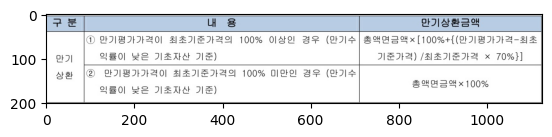

주어진 이미지를 분석한 결과, 이는 파생결합증권(DLS)의 만기상환 조건을 설명하는 표입니다.

## <title>
미래에셋증권 제253회 파생결합증권(DLS) 만기상환 조건표

## <summary>
이 표는 원금보장형 DLS 상품의 만기상환 조건을 두 가지 시나리오로 구분하여 설명합니다. 만기평가가격이 최초기준가격의 100% 이상인지 미만인지에 따라 상환금액이 달라지며, 100% 미만인 경우에도 원금이 보장됩니다.

## <entities>
1. **만기평가가격**: 만기일(2012년 7월 3일)의 기초자산 종가로 결정되는 가격
2. **최초기준가격**: 2011년 7월 7일의 기초자산 종가로 결정되는 기준 가격
3. **만기상환금액**: 투자자가 만기에 받게 되는 최종 상환금액
4. **총액면금액**: 투자자가 최초에 투자한 원금
5. **기초자산**: KOSPI200 지수와 금가격지수 두 개의 기초자산
6. **70% 참여율**: 수익률 계산 시 적용되는 참여 비율

## <hypothetical_questions>
1. 두 기초자산 모두 최초기준가격 대비 상승했을 때 수익률은 어떻게 계산되는가?
2. 한 기초자산은 상승하고 다른 기초자산은 하락했을 때 어떤 기준으로 수익률이 결정되는가?
3. 두 기초자산 모두 최초기준가격보다 하락했을 때도 원금이 보장되는가?
4. 참여율 70%가 최종 수익률에 미치는 영향은 무엇인가?
5. 만기평가가격이 정확히 최초기준가격과 같을 때는 어떤 조건이 적용되는가?

이 상품은 원금보장형 구조로 설계되어 있어, 기초자산의 성과가 좋지 않더라도 투자원금은 보장받을 수 있는 특징을 가지고 있습니다.

INFO:retry-bedrock-invocation:in retry(), summary_img() returned '주어진 이미지를 분석한 결과, 이는 파생결합증권(DLS)의 만기상환 조건을 설명하는 표입니다.

## <title>
미래에셋증권 제253회 파생결합증권(DLS) 만기상환 조건표

## <summary>
이 표는 원금보장형 DLS 상품의 만기상환 조건을 두 가지 시나리오로 구분하여 설명합니다. 만기평가가격이 최초기준가격의 100% 이상인지 미만인지에 따라 상환금액이 달라지며, 100% 미만인 경우에도 원금이 보장됩니다.

## <entities>
1. **만기평가가격**: 만기일(2012년 7월 3일)의 기초자산 종가로 결정되는 가격
2. **최초기준가격**: 2011년 7월 7일의 기초자산 종가로 결정되는 기준 가격
3. **만기상환금액**: 투자자가 만기에 받게 되는 최종 상환금액
4. **총액면금액**: 투자자가 최초에 투자한 원금
5. **기초자산**: KOSPI200 지수와 금가격지수 두 개의 기초자산
6. **70% 참여율**: 수익률 계산 시 적용되는 참여 비율

## <hypothetical_questions>
1. 두 기초자산 모두 최초기준가격 대비 상승했을 때 수익률은 어떻게 계산되는가?
2. 한 기초자산은 상승하고 다른 기초자산은 하락했을 때 어떤 기준으로 수익률이 결정되는가?
3. 두 기초자산 모두 최초기준가격보다 하락했을 때도 원금이 보장되는가?
4. 참여율 70%가 최종 수익률에 미치는 영향은 무엇인가?
5. 만기평가가격이 정확히 최초기준가격과 같을 때는 어떤 조건이 적용되는가?

이 상품은 원금보장형 구조로 설계되어 있어, 기초자산의 성과가 좋지 않더라도 투자원금은 보장받을 수 있는 특징을 가지고 있습니다.'
INFO:retry-bedrock-invocation:trying summary_img() [1/5]



==
0


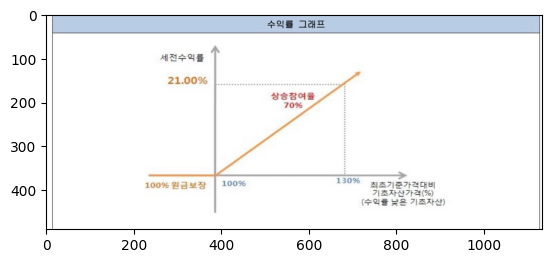

주어진 이미지와 contexts를 분석한 결과는 다음과 같습니다:

## <title>
수익률 그래프 - 금융상품 손익구조

## <summary>
이 그래프는 금융상품의 손익구조를 보여주는 것으로, 기초자산 가격 변동에 따른 세전 수익률을 나타냅니다. X축은 최초기준가격 대비 기초자산 가격 변동률(100%~130%)을, Y축은 세전 수익률(최대 21.00%)을 표시합니다. 상승참여율 70%가 적용되어 기초자산이 상승할 때 일정 비율로 수익에 참여하는 구조를 보여줍니다.

## <entities>
- **세전수익률**: 세금을 제하기 전의 투자 수익률로, 최대 21.00%까지 가능
- **기초자산가격**: KOSPI200과 금가격지수가 기초자산으로 사용됨
- **상승참여율 70%**: 기초자산이 상승할 때 실제 수익률에 70%만 반영되는 비율
- **100% 원금보장**: 기초자산 가격이 하락해도 원금은 보장되는 구조
- **최초기준가격결정일**: KOSPI200 250pt, 금가격지수 $1,500를 기준으로 설정
- **만기평가일**: 상품 만료 시점에서 손익을 결정하는 날짜

## <hypothetical_questions>
1. 기초자산이 130% 상승했을 때 실제 수익률은 얼마가 될까요?
2. KOSPI200이 20% 상승하고 금가격이 10% 하락한 경우의 수익률은?
3. 원금보장 조건이 어떤 상황에서 적용되는가?
4. 상승참여율 70%의 의미와 실제 수익 계산 방법은?
5. 1억원 투자 시 최대 수익금은 얼마인가?

이 상품은 원금을 보장하면서도 기초자산 상승 시 제한적이지만 수익 참여가 가능한 구조화 상품으로 보입니다.

INFO:retry-bedrock-invocation:in retry(), summary_img() returned '주어진 이미지와 contexts를 분석한 결과는 다음과 같습니다:

## <title>
수익률 그래프 - 금융상품 손익구조

## <summary>
이 그래프는 금융상품의 손익구조를 보여주는 것으로, 기초자산 가격 변동에 따른 세전 수익률을 나타냅니다. X축은 최초기준가격 대비 기초자산 가격 변동률(100%~130%)을, Y축은 세전 수익률(최대 21.00%)을 표시합니다. 상승참여율 70%가 적용되어 기초자산이 상승할 때 일정 비율로 수익에 참여하는 구조를 보여줍니다.

## <entities>
- **세전수익률**: 세금을 제하기 전의 투자 수익률로, 최대 21.00%까지 가능
- **기초자산가격**: KOSPI200과 금가격지수가 기초자산으로 사용됨
- **상승참여율 70%**: 기초자산이 상승할 때 실제 수익률에 70%만 반영되는 비율
- **100% 원금보장**: 기초자산 가격이 하락해도 원금은 보장되는 구조
- **최초기준가격결정일**: KOSPI200 250pt, 금가격지수 $1,500를 기준으로 설정
- **만기평가일**: 상품 만료 시점에서 손익을 결정하는 날짜

## <hypothetical_questions>
1. 기초자산이 130% 상승했을 때 실제 수익률은 얼마가 될까요?
2. KOSPI200이 20% 상승하고 금가격이 10% 하락한 경우의 수익률은?
3. 원금보장 조건이 어떤 상황에서 적용되는가?
4. 상승참여율 70%의 의미와 실제 수익 계산 방법은?
5. 1억원 투자 시 최대 수익금은 얼마인가?

이 상품은 원금을 보장하면서도 기초자산 상승 시 제한적이지만 수익 참여가 가능한 구조화 상품으로 보입니다.'
INFO:retry-bedrock-invocation:trying summary_img() [1/5]



==
1


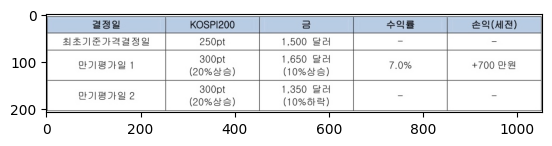

제공된 이미지와 테이블을 분석한 결과, 다음과 같은 정보를 추출할 수 있습니다:

## <title>
투자손익 시뮬레이션 표 - KOSPI200과 금 연계 금융상품

## <summary>
이 표는 KOSPI200 지수와 금 가격의 변동에 따른 투자 수익률과 손익을 보여주는 시뮬레이션 결과입니다. 최초기준가격(KOSPI200 250pt, 금 $1,500) 대비 만기평가일 1과 2의 서로 다른 시나리오에서의 수익률과 세후 손익을 제시하고 있습니다.

## <entities>
- **결정일**: 투자상품의 평가 시점을 나타내는 구분
- **KOSPI200**: 한국 주식시장의 대표 지수로, 250pt에서 300pt로 20% 상승한 시나리오
- **금**: 금 가격 지수로, $1,500에서 $1,650(10% 상승) 또는 $1,350(10% 하락)의 시나리오
- **수익률**: 투자원금 대비 얻은 수익의 비율 (7.0%)
- **손익(세전)**: 세금을 제외한 실제 투자손익 금액 (+700만원)

## <hypothetical_questions>
표에서 직접적인 질문은 제시되지 않았으나, 다음과 같은 가상 질문들을 도출할 수 있습니다:

1. KOSPI200이 20% 상승하고 금이 10% 상승할 때의 수익률은 얼마인가?
2. 1억원 투자 시 만기평가일 1 조건에서 세전 손익은 얼마인가?
3. 금 가격이 10% 하락했을 때(만기평가일 2)의 수익률은 어떻게 되는가?
4. 두 시나리오 간 수익률 차이는 무엇 때문인가?

이 표는 금융상품의 핵심설명서 일부로, 투자자가 다양한 시장 상황에서의 예상 수익률을 이해할 수 있도록 돕는 자료입니다.

INFO:retry-bedrock-invocation:in retry(), summary_img() returned '제공된 이미지와 테이블을 분석한 결과, 다음과 같은 정보를 추출할 수 있습니다:

## <title>
투자손익 시뮬레이션 표 - KOSPI200과 금 연계 금융상품

## <summary>
이 표는 KOSPI200 지수와 금 가격의 변동에 따른 투자 수익률과 손익을 보여주는 시뮬레이션 결과입니다. 최초기준가격(KOSPI200 250pt, 금 $1,500) 대비 만기평가일 1과 2의 서로 다른 시나리오에서의 수익률과 세후 손익을 제시하고 있습니다.

## <entities>
- **결정일**: 투자상품의 평가 시점을 나타내는 구분
- **KOSPI200**: 한국 주식시장의 대표 지수로, 250pt에서 300pt로 20% 상승한 시나리오
- **금**: 금 가격 지수로, $1,500에서 $1,650(10% 상승) 또는 $1,350(10% 하락)의 시나리오
- **수익률**: 투자원금 대비 얻은 수익의 비율 (7.0%)
- **손익(세전)**: 세금을 제외한 실제 투자손익 금액 (+700만원)

## <hypothetical_questions>
표에서 직접적인 질문은 제시되지 않았으나, 다음과 같은 가상 질문들을 도출할 수 있습니다:

1. KOSPI200이 20% 상승하고 금이 10% 상승할 때의 수익률은 얼마인가?
2. 1억원 투자 시 만기평가일 1 조건에서 세전 손익은 얼마인가?
3. 금 가격이 10% 하락했을 때(만기평가일 2)의 수익률은 어떻게 되는가?
4. 두 시나리오 간 수익률 차이는 무엇 때문인가?

이 표는 금융상품의 핵심설명서 일부로, 투자자가 다양한 시장 상황에서의 예상 수익률을 이해할 수 있도록 돕는 자료입니다.'



==
2


In [43]:
summaries = []
for idx, doc in enumerate(docs_for_summary):
    summary = summary_img(summarize_chain, doc["target_base64"], doc["contexts_markdown"])
    summaries.append(summary)
    print ("\n==")
    print (idx)

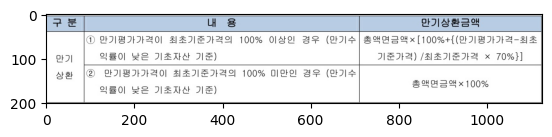

Summary: 주어진 이미지를 분석한 결과, 이는 파생결합증권(DLS)의 만기상환 조건을 설명하는 표입니다.

## <title>
미래에셋증권 제253회 파생결합증권(DLS) 만기상환 조건표

## <summary>
이 표는 원금보장형 DLS 상품의 만기상환 조건을 두 가지 시나리오로 구분하여 설명합니다. 만기평가가격이 최초기준가격의 100% 이상인지 미만인지에 따라 상환금액이 달라지며, 100% 미만인 경우에도 원금이 보장됩니다.

## <entities>
1. **만기평가가격**: 만기일(2012년 7월 3일)의 기초자산 종가로 결정되는 가격
2. **최초기준가격**: 2011년 7월 7일의 기초자산 종가로 결정되는 기준 가격
3. **만기상환금액**: 투자자가 만기에 받게 되는 최종 상환금액
4. **총액면금액**: 투자자가 최초에 투자한 원금
5. **기초자산**: KOSPI200 지수와 금가격지수 두 개의 기초자산
6. **70% 참여율**: 수익률 계산 시 적용되는 참여 비율

## <hypothetical_questions>
1. 두 기초자산 모두 최초기준가격 대비 상승했을 때 수익률은 어떻게 계산되는가?
2. 한 기초자산은 상승하고 다른 기초자산은 하락했을 때 어떤 기준으로 수익률이 결정되는가?
3. 두 기초자산 모두 최초기준가격보다 하락했을 때도 원금이 보장되는가?
4. 참여율 70%가 최종 수익률에 미치는 영향은 무엇인가?
5. 만기평가가격이 정확히 최초기준가격과 같을 때는 어떤 조건이 적용되는가?

이 상품은 원금보장형 구조로 설계되어 있어, 기초자산의 성과가 좋지 않더라도 투자원금은 보장받을 수 있는 특징을 가지고 있습니다.


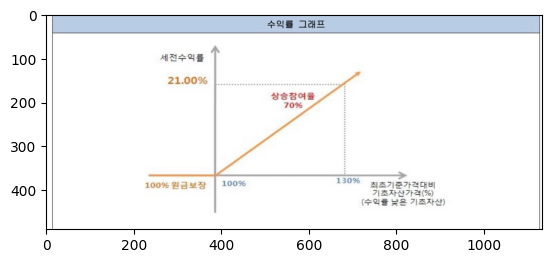

Summary: 주어진 이미지와 contexts를 분석한 결과는 다음과 같습니다:

## <title>
수익률 그래프 - 금융상품 손익구조

## <summary>
이 그래프는 금융상품의 손익구조를 보여주는 것으로, 기초자산 가격 변동에 따른 세전 수익률을 나타냅니다. X축은 최초기준가격 대비 기초자산 가격 변동률(100%~130%)을, Y축은 세전 수익률(최대 21.00%)을 표시합니다. 상승참여율 70%가 적용되어 기초자산이 상승할 때 일정 비율로 수익에 참여하는 구조를 보여줍니다.

## <entities>
- **세전수익률**: 세금을 제하기 전의 투자 수익률로, 최대 21.00%까지 가능
- **기초자산가격**: KOSPI200과 금가격지수가 기초자산으로 사용됨
- **상승참여율 70%**: 기초자산이 상승할 때 실제 수익률에 70%만 반영되는 비율
- **100% 원금보장**: 기초자산 가격이 하락해도 원금은 보장되는 구조
- **최초기준가격결정일**: KOSPI200 250pt, 금가격지수 $1,500를 기준으로 설정
- **만기평가일**: 상품 만료 시점에서 손익을 결정하는 날짜

## <hypothetical_questions>
1. 기초자산이 130% 상승했을 때 실제 수익률은 얼마가 될까요?
2. KOSPI200이 20% 상승하고 금가격이 10% 하락한 경우의 수익률은?
3. 원금보장 조건이 어떤 상황에서 적용되는가?
4. 상승참여율 70%의 의미와 실제 수익 계산 방법은?
5. 1억원 투자 시 최대 수익금은 얼마인가?

이 상품은 원금을 보장하면서도 기초자산 상승 시 제한적이지만 수익 참여가 가능한 구조화 상품으로 보입니다.


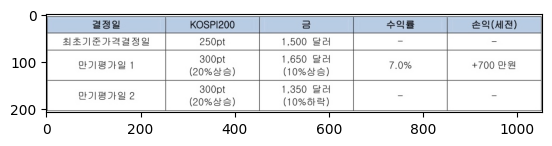

Summary: 제공된 이미지와 테이블을 분석한 결과, 다음과 같은 정보를 추출할 수 있습니다:

## <title>
투자손익 시뮬레이션 표 - KOSPI200과 금 연계 금융상품

## <summary>
이 표는 KOSPI200 지수와 금 가격의 변동에 따른 투자 수익률과 손익을 보여주는 시뮬레이션 결과입니다. 최초기준가격(KOSPI200 250pt, 금 $1,500) 대비 만기평가일 1과 2의 서로 다른 시나리오에서의 수익률과 세후 손익을 제시하고 있습니다.

## <entities>
- **결정일**: 투자상품의 평가 시점을 나타내는 구분
- **KOSPI200**: 한국 주식시장의 대표 지수로, 250pt에서 300pt로 20% 상승한 시나리오
- **금**: 금 가격 지수로, $1,500에서 $1,650(10% 상승) 또는 $1,350(10% 하락)의 시나리오
- **수익률**: 투자원금 대비 얻은 수익의 비율 (7.0%)
- **손익(세전)**: 세금을 제외한 실제 투자손익 금액 (+700만원)

## <hypothetical_questions>
표에서 직접적인 질문은 제시되지 않았으나, 다음과 같은 가상 질문들을 도출할 수 있습니다:

1. KOSPI200이 20% 상승하고 금이 10% 상승할 때의 수익률은 얼마인가?
2. 1억원 투자 시 만기평가일 1 조건에서 세전 손익은 얼마인가?
3. 금 가격이 10% 하락했을 때(만기평가일 2)의 수익률은 어떻게 되는가?
4. 두 시나리오 간 수익률 차이는 무엇 때문인가?

이 표는 금융상품의 핵심설명서 일부로, 투자자가 다양한 시장 상황에서의 예상 수익률을 이해할 수 있도록 돕는 자료입니다.


In [44]:
verbose = True
if verbose:
    for doc, summary in zip(docs_for_summary, summaries):

        print ("============================")
        img = Image.open(BytesIO(base64.b64decode(doc["target_base64"])))
        plt.imshow(img)
        plt.show()

        print (f'Summary: {summary}')

`요약`된 내용을 Document의 `page_content`로, `OCR`결과는 metadata의 `origin_image`로 사용

In [45]:
images_preprocessed = []

for doc, summary in zip(docs_for_summary, summaries):
    
    metadata = {}
    metadata["markdown"] = doc["target_markdown"]
    metadata["category"] = "Image"
    metadata["image_base64"] = doc["target_base64"]
    
    doc = Document(
        page_content=summary,
        metadata=metadata
    )
    images_preprocessed.append(doc)

In [46]:
images_preprocessed[0]

Document(metadata={'markdown': '| 구 분 | 내 용 | 만기상환금액 |\n| --- | --- | --- |\n| 만기 상환 | ① 만기평가가격이 최초기준가격의 100% 이상인 경우 (만기수 익률이 낮은 기초자산 기준) | 총액면금액×[100%+{(만기평가가격-최초 기준가격) /최초기준가격 × 70%}] |\n| 만기 상환 | ② 만기평가가격이 최초기준가격의 100% 미만인 경우 (만기수 익률이 낮은 기초자산 기준) | 총액면금액×100% |\n', 'category': 'Image', 'image_base64': '/9j/2wCEAAIBAQEBAQIBAQECAgICAgQDAgICAgUEBAMEBgUGBgYFBgYGBwkIBgcJBwYGCAsICQoKCgoKBggLDAsKDAkKCgoBAgICAgICBQMDBQoHBgcKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCv/AABEIAMoEZgMBIgACEQEDEQH/xAGiAAABBQEBAQEBAQAAAAAAAAAAAQIDBAUGBwgJCgsQAAIBAwMCBAMFBQQEAAABfQECAwAEEQUSITFBBhNRYQcicRQygZGhCCNCscEVUtHwJDNicoIJChYXGBkaJSYnKCkqNDU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6g4SFhoeIiYqSk5SVlpeYmZqio6Slpqeoqaqys7S1tre4ubrCw8TFxsfIycrS09TV1tfY2drh4uPk5ebn6Onq8fLz9PX29/j5+gEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoLEQACAQIEBAMEBwUEBAABAncAAQIDEQQFITEGEkFRB2FxEyIygQgUQpGhscEJIzNS8BVictEKFiQ04SXxFxgZGiYnKCkqNTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqCg4SFhoeIiYqSk5SVlpeYm

### For tables (summary for markdown)
- 테이블의 경우 이미지 뿐만 아니라 마크다운 형태로도 가지고 있음

In [47]:
tables = [doc for doc in docs_for_summary if doc["target_category"] == "table"]

In [48]:
human_prompt = [
    {
        "type": "text",
        "text": '''
                 Here is the table: <table>{table}</table>
                 Given table, give a concise summary.
                 Don't insert any XML tag such as <table> and </table> when answering.
                 Write in Korean.
        '''
    },
]
human_message_template = HumanMessagePromptTemplate.from_template(human_prompt)

In [49]:
prompt = ChatPromptTemplate.from_messages(
    [
        system_message_template,
        human_message_template
    ]
)

#summarize_chain = prompt | llm_text | StrOutputParser()
summarize_chain = {"table": lambda x:x} | prompt | llm_text | StrOutputParser()

In [50]:
table_info = [t["target_markdown"] for t in tables]
table_summaries = summarize_chain.batch(table_info, config={"max_concurrency": 1})

이 표는 만기 상환 조건에 따른 상환금액을 설명하는 금융상품의 구조입니다.

**주요 내용:**

1. **만기평가가격이 최초기준가격의 100% 이상인 경우:**
   - 수익률이 낮은 기초자산을 기준으로 함
   - 상환금액 = 총액면금액 × [100% + (만기평가가격-최초기준가격)/최초기준가격 × 70%]
   - 즉, 원금 보장 + 상승분의 70% 수익 참여

2. **만기평가가격이 최초기준가격의 100% 미만인 경우:**
   - 수익률이 낮은 기초자산을 기준으로 함  
   - 상환금액 = 총액면금액 × 100%
   - 즉, 원금만 상환 (손실 발생 시에도 원금 보장)

이는 원금보장형 파생결합증권(DLS)의 전형적인 구조로, 하락 시 원금을 보장하고 상승 시 일정 비율의 수익을 제공하는 상품입니다.이 표는 KOSPI200과 금을 기초자산으로 하는 투자상품의 성과를 보여줍니다.

최초 기준가격은 KOSPI200 250pt, 금 1,500달러로 설정되었습니다.

만기평가일 1에서는 KOSPI200이 300pt로 20% 상승하고 금이 1,650달러로 10% 상승했을 때, 7.0%의 수익률을 달성하여 700만원의 이익을 기록했습니다.

만기평가일 2에서는 KOSPI200은 여전히 300pt(20% 상승)를 유지했지만, 금이 1,350달러로 10% 하락한 결과 수익률과 손익이 발생하지 않았습니다.

이는 두 기초자산이 모두 상승해야만 수익이 발생하는 구조임을 보여줍니다.

`요약`된 내용을 Document의 `page_content`로, `parsed table`은 metadata의 `origin_table`로 사용

In [51]:
tables_preprocessed = []

for doc, summary in zip(tables, table_summaries):
    
    metadata = {}
    metadata["origin_table"] = doc["target_markdown"]
    metadata["text_as_html"] = doc["target_markdown"]
    metadata["category"] = "Table"
    metadata["image_base64"] = doc["target_base64"]
    
    doc = Document(
        page_content=summary,
        metadata=metadata
    )
    tables_preprocessed.append(doc)

In [52]:
tables_preprocessed[0]

Document(metadata={'origin_table': '| 구 분 | 내 용 | 만기상환금액 |\n| --- | --- | --- |\n| 만기 상환 | ① 만기평가가격이 최초기준가격의 100% 이상인 경우 (만기수 익률이 낮은 기초자산 기준) | 총액면금액×[100%+{(만기평가가격-최초 기준가격) /최초기준가격 × 70%}] |\n| 만기 상환 | ② 만기평가가격이 최초기준가격의 100% 미만인 경우 (만기수 익률이 낮은 기초자산 기준) | 총액면금액×100% |\n', 'text_as_html': '| 구 분 | 내 용 | 만기상환금액 |\n| --- | --- | --- |\n| 만기 상환 | ① 만기평가가격이 최초기준가격의 100% 이상인 경우 (만기수 익률이 낮은 기초자산 기준) | 총액면금액×[100%+{(만기평가가격-최초 기준가격) /최초기준가격 × 70%}] |\n| 만기 상환 | ② 만기평가가격이 최초기준가격의 100% 미만인 경우 (만기수 익률이 낮은 기초자산 기준) | 총액면금액×100% |\n', 'category': 'Table', 'image_base64': '/9j/2wCEAAIBAQEBAQIBAQECAgICAgQDAgICAgUEBAMEBgUGBgYFBgYGBwkIBgcJBwYGCAsICQoKCgoKBggLDAsKDAkKCgoBAgICAgICBQMDBQoHBgcKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCv/AABEIAMoEZgMBIgACEQEDEQH/xAGiAAABBQEBAQEBAQAAAAAAAAAAAQIDBAUGBwgJCgsQAAIBAwMCBAMFBQQEAAABfQECAwAEEQUSITFBBhNRYQcicRQygZGhCCNCscEVUtHwJDNicoIJChYXGBkaJSYnKCkqNDU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6g4SFhoeIiYqSk5SVlpeYmZqio6Slpqeoqaqys7S1tre

0
table: | 구 분 | 내 용 | 만기상환금액 |
| --- | --- | --- |
| 만기 상환 | ① 만기평가가격이 최초기준가격의 100% 이상인 경우 (만기수 익률이 낮은 기초자산 기준) | 총액면금액×[100%+{(만기평가가격-최초 기준가격) /최초기준가격 × 70%}] |
| 만기 상환 | ② 만기평가가격이 최초기준가격의 100% 미만인 경우 (만기수 익률이 낮은 기초자산 기준) | 총액면금액×100% |

----------------------------
summary: 이 표는 만기 상환 조건에 따른 상환금액을 설명하는 금융상품의 구조입니다.

**주요 내용:**

1. **만기평가가격이 최초기준가격의 100% 이상인 경우:**
   - 수익률이 낮은 기초자산을 기준으로 함
   - 상환금액 = 총액면금액 × [100% + (만기평가가격-최초기준가격)/최초기준가격 × 70%]
   - 즉, 원금 보장 + 상승분의 70% 수익 참여

2. **만기평가가격이 최초기준가격의 100% 미만인 경우:**
   - 수익률이 낮은 기초자산을 기준으로 함  
   - 상환금액 = 총액면금액 × 100%
   - 즉, 원금만 상환 (손실 발생 시에도 원금 보장)

이는 원금보장형 파생결합증권(DLS)의 전형적인 구조로, 하락 시 원금을 보장하고 상승 시 일정 비율의 수익을 제공하는 상품입니다.
----------------------------
----------------------------
image


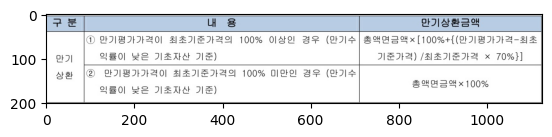

1
table: | 결정일 | KOSPI200 | 금 | 수익률 | 손익(세전) |
| --- | --- | --- | --- | --- |
| 최초기준가격결정일 | 250pt | 1,500 달러 | - | - |
| 만기평가일 1 | 300pt (20%상승) | 1,650 달러 (10%상승) | 7.0% | +700 만원 |
| 만기평가일 2 | 300pt (20%상승) | 1,350 달러 (10%하락) | - | - |

----------------------------
summary: 이 표는 KOSPI200과 금을 기초자산으로 하는 투자상품의 성과를 보여줍니다.

최초 기준가격은 KOSPI200 250pt, 금 1,500달러로 설정되었습니다.

만기평가일 1에서는 KOSPI200이 300pt로 20% 상승하고 금이 1,650달러로 10% 상승했을 때, 7.0%의 수익률을 달성하여 700만원의 이익을 기록했습니다.

만기평가일 2에서는 KOSPI200은 여전히 300pt(20% 상승)를 유지했지만, 금이 1,350달러로 10% 하락한 결과 수익률과 손익이 발생하지 않았습니다.

이는 두 기초자산이 모두 상승해야만 수익이 발생하는 구조임을 보여줍니다.
----------------------------
----------------------------
image


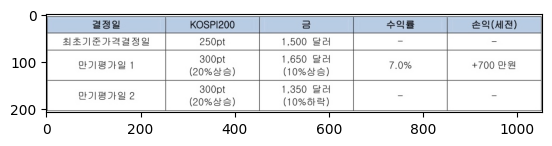

In [53]:
verbose = True
index = 0
if verbose:
    for table, summary in zip(tables, table_summaries):

        #if table_as_image:
        #page_contents, table_as_html, img_base64 = table
        category, img_base64, table_as_html, page_contents = table["target_category"], table["target_base64"], table["target_markdown"], table["target_markdown"]
        #else: page_contents, table_as_html = table

        print ("============================")
        print (index)
        print (f'table: {page_contents}')
        print ("----------------------------")
        print (f'summary: {summary}')
        print ("----------------------------")

        print ("----------------------------")
        if img_base64 is not None:
            print ("image")
            img = Image.open(BytesIO(base64.b64decode(img_base64)))
            plt.imshow(img)
            plt.show()
        index += 1


## 4. Index 생성
Document로 부터 추출한 text, table, 그리고 image 정보를 Amazon OpenSearch에 저장합니다. (인덱싱)  

### Index 이름 결정

In [54]:
import boto3
from src.utils.ssm import parameter_store

In [55]:
region=boto3.Session().region_name
pm = parameter_store(region)

In [56]:
index_name = "complex-doc-index"

In [57]:
pm.put_params(
    key="opensearch_index_name",
    value=f'{index_name}',
    overwrite=True,
    enc=False
)

Parameter stored successfully.


### Index 스키마 정의

In [58]:
index_body = {
    'settings': {
        'analysis': {
            'analyzer': {
                'my_analyzer': {
                         'char_filter':['html_strip'],
                    'tokenizer': 'nori',
                    'filter': [
                        #'nori_number',
                        #'lowercase',
                        #'trim',
                        'my_nori_part_of_speech'
                    ],
                    'type': 'custom'
                }
            },
            'tokenizer': {
                'nori': {
                    'decompound_mode': 'mixed',
                    'discard_punctuation': 'true',
                    'type': 'nori_tokenizer'
                }
            },
            "filter": {
                "my_nori_part_of_speech": {
                    "type": "nori_part_of_speech",
                    "stoptags": [
                        "J", "XSV", "E", "IC","MAJ","NNB",
                        "SP", "SSC", "SSO",
                        "SC","SE","XSN","XSV",
                        "UNA","NA","VCP","VSV",
                        "VX"
                    ]
                }
            }
        },
        'index': {
            'knn': True,
            'knn.space_type': 'cosinesimil'  # Example space type
        }
    },
    'mappings': {
        'properties': {
            'metadata': {
                'properties': {
                    'source': {'type': 'keyword'},
                    'page_number': {'type':'long'},
                    'category': {'type':'text'},
                    'file_directory': {'type':'text'},
                    'last_modified': {'type': 'text'},
                    'type': {'type': 'keyword'},
                    'image_base64': {'type':'text'},
                    'origin_image': {'type':'text'},
                    'origin_table': {'type':'text'},
                }
            },
            'text': {
                'analyzer': 'my_analyzer',
                'search_analyzer': 'my_analyzer',
                'type': 'text'
            },
            'vector_field': {
                'type': 'knn_vector',
                'dimension': f"{dimension}" # Replace with your vector dimension
            }
        }
    }
}


## 5. LangChain OpenSearch VectorStore 생성 
### 선수 조건

#### [중요] 아래에 aws parameter store 에 아래 인증정보가 먼저 입력되어 있어야 합니다.

In [59]:
opensearch_domain_endpoint = pm.get_params(
    key="opensearch_domain_endpoint",
    enc=False
)

opensearch_user_id = pm.get_params(
    key="opensearch_user_id",
    enc=False
)

opensearch_user_password = pm.get_params(
    key="opensearch_user_password",
    enc=True
)

In [60]:
opensearch_domain_endpoint = opensearch_domain_endpoint
rag_user_name = opensearch_user_id
rag_user_password = opensearch_user_password

http_auth = (rag_user_name, rag_user_password) # Master username, Master password

### OpenSearch Client 생성

In [61]:
from src.utils.opensearch import opensearch_utils

In [62]:
aws_region = os.environ.get("AWS_DEFAULT_REGION", None)

os_client = opensearch_utils.create_aws_opensearch_client(
    aws_region,
    opensearch_domain_endpoint,
    http_auth
)

### 오픈 서치 인덱스 생성 
- 오픈 서치에 해당 인덱스가 존재하면, 삭제 합니다. 

In [63]:
index_exists = opensearch_utils.check_if_index_exists(
    os_client,
    index_name
)

if index_exists:
    opensearch_utils.delete_index(
        os_client,
        index_name
    )

opensearch_utils.create_index(os_client, index_name, index_body)
index_info = os_client.indices.get(index=index_name)
print("Index is created")
pprint(index_info)

index_name=complex-doc-index, exists=True

Deleting index:
{'acknowledged': True}

Creating index:
{'acknowledged': True, 'shards_acknowledged': True, 'index': 'complex-doc-index'}
Index is created
{'complex-doc-index': {'aliases': {},
                       'mappings': {'properties': {'metadata': {'properties': {'category': {'type': 'text'},
                                                                               'file_directory': {'type': 'text'},
                                                                               'image_base64': {'type': 'text'},
                                                                               'last_modified': {'type': 'text'},
                                                                               'origin_image': {'type': 'text'},
                                                                               'origin_table': {'type': 'text'},
                                                                               'page_nu

### 랭체인 인덱스 연결 오브젝트 생성

- [langchain.vectorstores.opensearch_vector_search.OpenSearchVectorSearch](https://api.python.langchain.com/en/latest/vectorstores/langchain.vectorstores.opensearch_vector_search.OpenSearchVectorSearch.html)

In [65]:
from langchain_community.vectorstores import OpenSearchVectorSearch

In [66]:
vector_db = OpenSearchVectorSearch(
    index_name=index_name,
    opensearch_url=opensearch_domain_endpoint,
    embedding_function=llm_emb,
    http_auth=http_auth, # http_auth
    is_aoss=False,
    engine="faiss",
    space_type="l2",
    bulk_size=100000,
    timeout=60
)
vector_db

### Chunking Strategy: Parent documents
* Chunk Size and Chunk Overlap Size

In [69]:
from src.utils.chunk import parant_documents

In [70]:
parent_chunk_size = 1024 # 4096 
parent_chunk_overlap = 0

child_chunk_size = 256 # 1024
child_chunk_overlap = 64 # 256 

opensearch_parent_key_name = "parent_id"
opensearch_family_tree_key_name = "family_tree"

* Parent Chunking
    - create_parent_chunk() 아래와 같은 작업을 합니다.
    - all_docs 에 있는 문서를 parent_chunk_size 만큼으로 청킹 합니다.
    - Parent Chunk 에 두개의 메타 데이타를 생성 합니다.
        - family_tree: parent
        - parent_id : None

In [71]:
texts[0].page_content

'핵 심 설 명 서\n\n이 설명서는 금융소비자의 권익 보호 및 금융상품에 대한 이해 증진을 위하여\n금융상품의 핵심내용을 쉽게 이해하실 수 있도록 작성한 것입니다. 상품내용을\n충분히 이해하신 다음에 청약여부를 결정하시기 바랍니다.\n\n# 핵심설명서\n\n# [미래에셋증권 제 253 회 파생결합증권(DLS)(원금보장형)]\n\n# 1\n\n# 상품 개요\n\n- ○ 모집가액: 100 억원 (모집된 금액이 10 억 미만일 경우 발행이 취소될 수 있음)\n- ○ 기초자산: KOSPI200 지수(블룸버그 Ticker: KOSPI2 index),\n- 금가격지수 (블룸버그 Ticker: GOLDLNPM index)\n- ○ 청약기간 : 2011 년 07 월 04 일 ~2011 년 07 월 07 일 16 시\n- ○ 청약단위 : 100 만원 이상 100 만원 단위 (발행 후 추가 납입 불가)\n- ○ 발 행 일 : 2011 년 07 월 08 일\n- ○ 만 기 일 : 2012 년 07 월 09 일(만기 1 년)\n- ○ 상품위험등급: 4 등급\n\n\n# 2\n\n# 기준가격 결정일 및 평가방법\n\n- ○ 최초 기준가격: 2011 년 07 월 07 일의 종가(해당 거래소 기준)\n- ○ 만기 평가가격: 2012 년 07 월 03 일의 종가(해당 거래소 기준)\n\n\n# 3 손익 구조\n\n| 구 분 | 내 용 | 만기상환금액 |\n| --- | --- | --- |\n| 만기 상환 | ① 만기평가가격이 최초기준가격의 100% 이상인 경우 (만기수 익률이 낮은 기초자산 기준) | 총액면금액×[100%+{(만기평가가격-최초 기준가격) /최초기준가격 × 70%}] |\n| 만기 상환 | ② 만기평가가격이 최초기준가격의 100% 미만인 경우 (만기수 익률이 낮은 기초자산 기준) | 총액면금액×100% |\n\n\n※ 만기수익률=(만기평가가격-최초기준가격)/최초기준가격\n(단, {(만기평가가격-최초기준가격)/최초기준가격×70%}은 소수점 다섯째자리 이하 절사)\n\n# 

In [72]:
parent_chunk_docs = parant_documents.create_parent_chunk(
    docs=texts,
    parent_id_key=opensearch_parent_key_name,
    family_tree_id_key=opensearch_family_tree_key_name,
    parent_chunk_size=parent_chunk_size,
    parent_chunk_overlap=parent_chunk_overlap
)
print(f'Number of parent_chunk_docs= {len(parent_chunk_docs)}')

Number of parent_chunk_docs= 4


In [73]:
parent_chunk_docs

[Document(metadata={'family_tree': 'parent', 'parent_id': None}, page_content='핵 심 설 명 서\n\n이 설명서는 금융소비자의 권익 보호 및 금융상품에 대한 이해 증진을 위하여\n금융상품의 핵심내용을 쉽게 이해하실 수 있도록 작성한 것입니다. 상품내용을\n충분히 이해하신 다음에 청약여부를 결정하시기 바랍니다.\n\n# 핵심설명서\n\n# [미래에셋증권 제 253 회 파생결합증권(DLS)(원금보장형)]\n\n# 1\n\n# 상품 개요\n\n- ○ 모집가액: 100 억원 (모집된 금액이 10 억 미만일 경우 발행이 취소될 수 있음)\n- ○ 기초자산: KOSPI200 지수(블룸버그 Ticker: KOSPI2 index),\n- 금가격지수 (블룸버그 Ticker: GOLDLNPM index)\n- ○ 청약기간 : 2011 년 07 월 04 일 ~2011 년 07 월 07 일 16 시\n- ○ 청약단위 : 100 만원 이상 100 만원 단위 (발행 후 추가 납입 불가)\n- ○ 발 행 일 : 2011 년 07 월 08 일\n- ○ 만 기 일 : 2012 년 07 월 09 일(만기 1 년)\n- ○ 상품위험등급: 4 등급\n\n\n# 2\n\n# 기준가격 결정일 및 평가방법\n\n- ○ 최초 기준가격: 2011 년 07 월 07 일의 종가(해당 거래소 기준)\n- ○ 만기 평가가격: 2012 년 07 월 03 일의 종가(해당 거래소 기준)\n\n\n# 3 손익 구조\n\n| 구 분 | 내 용 | 만기상환금액 |\n| --- | --- | --- |\n| 만기 상환 | ① 만기평가가격이 최초기준가격의 100% 이상인 경우 (만기수 익률이 낮은 기초자산 기준) | 총액면금액×[100%+{(만기평가가격-최초 기준가격) /최초기준가격 × 70%}] |\n| 만기 상환 | ② 만기평가가격이 최초기준가격의 100% 미만인 경우 (만기수 익률이 낮은 기초자산 기준) | 총액면금액×100% |\n\n\n※ 만기수익률=(만

* Insert doc into OpenSearch 

In [74]:
%%time

parent_ids = vector_db.add_documents(
    documents = parent_chunk_docs, 
    vector_field = "vector_field",
    bulk_size = 1000000
)

CPU times: user 89.9 ms, sys: 1.92 ms, total: 91.8 ms
Wall time: 777 ms


In [75]:
parent_chunk_docs

[Document(metadata={'family_tree': 'parent', 'parent_id': None}, page_content='핵 심 설 명 서\n\n이 설명서는 금융소비자의 권익 보호 및 금융상품에 대한 이해 증진을 위하여\n금융상품의 핵심내용을 쉽게 이해하실 수 있도록 작성한 것입니다. 상품내용을\n충분히 이해하신 다음에 청약여부를 결정하시기 바랍니다.\n\n# 핵심설명서\n\n# [미래에셋증권 제 253 회 파생결합증권(DLS)(원금보장형)]\n\n# 1\n\n# 상품 개요\n\n- ○ 모집가액: 100 억원 (모집된 금액이 10 억 미만일 경우 발행이 취소될 수 있음)\n- ○ 기초자산: KOSPI200 지수(블룸버그 Ticker: KOSPI2 index),\n- 금가격지수 (블룸버그 Ticker: GOLDLNPM index)\n- ○ 청약기간 : 2011 년 07 월 04 일 ~2011 년 07 월 07 일 16 시\n- ○ 청약단위 : 100 만원 이상 100 만원 단위 (발행 후 추가 납입 불가)\n- ○ 발 행 일 : 2011 년 07 월 08 일\n- ○ 만 기 일 : 2012 년 07 월 09 일(만기 1 년)\n- ○ 상품위험등급: 4 등급\n\n\n# 2\n\n# 기준가격 결정일 및 평가방법\n\n- ○ 최초 기준가격: 2011 년 07 월 07 일의 종가(해당 거래소 기준)\n- ○ 만기 평가가격: 2012 년 07 월 03 일의 종가(해당 거래소 기준)\n\n\n# 3 손익 구조\n\n| 구 분 | 내 용 | 만기상환금액 |\n| --- | --- | --- |\n| 만기 상환 | ① 만기평가가격이 최초기준가격의 100% 이상인 경우 (만기수 익률이 낮은 기초자산 기준) | 총액면금액×[100%+{(만기평가가격-최초 기준가격) /최초기준가격 × 70%}] |\n| 만기 상환 | ② 만기평가가격이 최초기준가격의 100% 미만인 경우 (만기수 익률이 낮은 기초자산 기준) | 총액면금액×100% |\n\n\n※ 만기수익률=(만

In [76]:
total_count_docs = opensearch_utils.get_count(os_client, index_name)
print("total count docs: ", total_count_docs)

total count docs:  {'count': 4, '_shards': {'total': 5, 'successful': 5, 'skipped': 0, 'failed': 0}}


* 삽입된 Parent Chunk 의 첫번째를 확인 합니다. family_tree, parent_id 의 값을 확인 하세요.
    - family_tree 가 parent의 경우, parent_id는 None입니다. (child가 속한 parent가 무엇인지 알려주는 용도기 때문)

In [77]:
def show_opensearch_doc_info(response):
    print("opensearch document id:" , response["_id"])
    print("family_tree:" , response["_source"]["metadata"]["family_tree"])
    print("parent document id:" , response["_source"]["metadata"]["parent_id"])
    print("parent document text: \n" , response["_source"]["text"])

response = opensearch_utils.get_document(os_client, doc_id = parent_ids[0], index_name = index_name)
show_opensearch_doc_info(response)

opensearch document id: cc4575b0-dfe6-48ad-8d15-c358a6a18b60
family_tree: parent
parent document id: None
parent document text: 
 핵 심 설 명 서

이 설명서는 금융소비자의 권익 보호 및 금융상품에 대한 이해 증진을 위하여
금융상품의 핵심내용을 쉽게 이해하실 수 있도록 작성한 것입니다. 상품내용을
충분히 이해하신 다음에 청약여부를 결정하시기 바랍니다.

# 핵심설명서

# [미래에셋증권 제 253 회 파생결합증권(DLS)(원금보장형)]

# 1

# 상품 개요

- ○ 모집가액: 100 억원 (모집된 금액이 10 억 미만일 경우 발행이 취소될 수 있음)
- ○ 기초자산: KOSPI200 지수(블룸버그 Ticker: KOSPI2 index),
- 금가격지수 (블룸버그 Ticker: GOLDLNPM index)
- ○ 청약기간 : 2011 년 07 월 04 일 ~2011 년 07 월 07 일 16 시
- ○ 청약단위 : 100 만원 이상 100 만원 단위 (발행 후 추가 납입 불가)
- ○ 발 행 일 : 2011 년 07 월 08 일
- ○ 만 기 일 : 2012 년 07 월 09 일(만기 1 년)
- ○ 상품위험등급: 4 등급


# 2

# 기준가격 결정일 및 평가방법

- ○ 최초 기준가격: 2011 년 07 월 07 일의 종가(해당 거래소 기준)
- ○ 만기 평가가격: 2012 년 07 월 03 일의 종가(해당 거래소 기준)


# 3 손익 구조

| 구 분 | 내 용 | 만기상환금액 |
| --- | --- | --- |
| 만기 상환 | ① 만기평가가격이 최초기준가격의 100% 이상인 경우 (만기수 익률이 낮은 기초자산 기준) | 총액면금액×[100%+{(만기평가가격-최초 기준가격) /최초기준가격 × 70%}] |
| 만기 상환 | ② 만기평가가격이 최초기준가격의 100% 미만인 경우 (만기수 익률이 낮은 기초자산 기준) | 총액면금액×100% |



* Child Chunking
    - 아래의 create_child_chunk() 는 다음과 같은 작업을 합니다.
    - parent_chunk_docs 각각에 대해서 Child Chunk 를 생성 합니다. 
    - Child Chunk 에 두개의 메타 데이타를 생성 합니다.
        - family_tree: child
        - parent_id : parent 에 대한 OpenSearch document id

In [78]:
child_chunk_docs = parant_documents.create_child_chunk(
    child_chunk_size=child_chunk_size,
    child_chunk_overlap=child_chunk_overlap,
    docs=parent_chunk_docs,
    parent_ids_value=parent_ids,
    parent_id_key=opensearch_parent_key_name,
    family_tree_id_key=opensearch_family_tree_key_name
)

print(f"Number of child_chunk_docs= {len(child_chunk_docs)}")

Number of child_chunk_docs= 18


In [79]:
child_chunk_docs[0]

Document(metadata={'family_tree': 'child', 'parent_id': 'cc4575b0-dfe6-48ad-8d15-c358a6a18b60'}, page_content='핵 심 설 명 서\n\n이 설명서는 금융소비자의 권익 보호 및 금융상품에 대한 이해 증진을 위하여\n금융상품의 핵심내용을 쉽게 이해하실 수 있도록 작성한 것입니다. 상품내용을\n충분히 이해하신 다음에 청약여부를 결정하시기 바랍니다.\n\n# 핵심설명서\n\n# [미래에셋증권 제 253 회 파생결합증권(DLS)(원금보장형)]\n\n# 1\n\n# 상품 개요')

In [80]:
parent_id = child_chunk_docs[0].metadata["parent_id"]
print("child's parent_id: ", parent_id)
print("\n###### Search parent in OpenSearch")
response = opensearch_utils.get_document(os_client, doc_id = parent_id, index_name = index_name)
show_opensearch_doc_info(response)    

child's parent_id:  cc4575b0-dfe6-48ad-8d15-c358a6a18b60

###### Search parent in OpenSearch
opensearch document id: cc4575b0-dfe6-48ad-8d15-c358a6a18b60
family_tree: parent
parent document id: None
parent document text: 
 핵 심 설 명 서

이 설명서는 금융소비자의 권익 보호 및 금융상품에 대한 이해 증진을 위하여
금융상품의 핵심내용을 쉽게 이해하실 수 있도록 작성한 것입니다. 상품내용을
충분히 이해하신 다음에 청약여부를 결정하시기 바랍니다.

# 핵심설명서

# [미래에셋증권 제 253 회 파생결합증권(DLS)(원금보장형)]

# 1

# 상품 개요

- ○ 모집가액: 100 억원 (모집된 금액이 10 억 미만일 경우 발행이 취소될 수 있음)
- ○ 기초자산: KOSPI200 지수(블룸버그 Ticker: KOSPI2 index),
- 금가격지수 (블룸버그 Ticker: GOLDLNPM index)
- ○ 청약기간 : 2011 년 07 월 04 일 ~2011 년 07 월 07 일 16 시
- ○ 청약단위 : 100 만원 이상 100 만원 단위 (발행 후 추가 납입 불가)
- ○ 발 행 일 : 2011 년 07 월 08 일
- ○ 만 기 일 : 2012 년 07 월 09 일(만기 1 년)
- ○ 상품위험등급: 4 등급


# 2

# 기준가격 결정일 및 평가방법

- ○ 최초 기준가격: 2011 년 07 월 07 일의 종가(해당 거래소 기준)
- ○ 만기 평가가격: 2012 년 07 월 03 일의 종가(해당 거래소 기준)


# 3 손익 구조

| 구 분 | 내 용 | 만기상환금액 |
| --- | --- | --- |
| 만기 상환 | ① 만기평가가격이 최초기준가격의 100% 이상인 경우 (만기수 익률이 낮은 기초자산 기준) | 총액면금액×[100%+{(만기평가가격-최초 기준가격) /최

### Manipulate table and image for parent documents
- set family_tree of table and image documents as "parent_table" and these kinds of types are included in searchable list (child, parent_table and parent_image) in parant document strategy.

In [81]:
for table in tables_preprocessed:
    table.metadata["family_tree"], table.metadata["parent_id"] = "parent_table", "NA"

In [82]:
for image in images_preprocessed:
    image.metadata["family_tree"], image.metadata["parent_id"] = "parent_image", "NA"

In [83]:
images_preprocessed

[Document(metadata={'markdown': '| 구 분 | 내 용 | 만기상환금액 |\n| --- | --- | --- |\n| 만기 상환 | ① 만기평가가격이 최초기준가격의 100% 이상인 경우 (만기수 익률이 낮은 기초자산 기준) | 총액면금액×[100%+{(만기평가가격-최초 기준가격) /최초기준가격 × 70%}] |\n| 만기 상환 | ② 만기평가가격이 최초기준가격의 100% 미만인 경우 (만기수 익률이 낮은 기초자산 기준) | 총액면금액×100% |\n', 'category': 'Image', 'image_base64': '/9j/2wCEAAIBAQEBAQIBAQECAgICAgQDAgICAgUEBAMEBgUGBgYFBgYGBwkIBgcJBwYGCAsICQoKCgoKBggLDAsKDAkKCgoBAgICAgICBQMDBQoHBgcKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCv/AABEIAMoEZgMBIgACEQEDEQH/xAGiAAABBQEBAQEBAQAAAAAAAAAAAQIDBAUGBwgJCgsQAAIBAwMCBAMFBQQEAAABfQECAwAEEQUSITFBBhNRYQcicRQygZGhCCNCscEVUtHwJDNicoIJChYXGBkaJSYnKCkqNDU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6g4SFhoeIiYqSk5SVlpeYmZqio6Slpqeoqaqys7S1tre4ubrCw8TFxsfIycrS09TV1tfY2drh4uPk5ebn6Onq8fLz9PX29/j5+gEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoLEQACAQIEBAMEBwUEBAABAncAAQIDEQQFITEGEkFRB2FxEyIygQgUQpGhscEJIzNS8BVictEKFiQ04SXxFxgZGiYnKCkqNTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqCg4SFhoeIiYqSk5SVlpeY

### Merge text, table and image

In [84]:
from itertools import chain

In [85]:
docs_preprocessed = list(chain(child_chunk_docs, tables_preprocessed, images_preprocessed))

* Insert doc into OpenSearch

In [86]:
%%time

child_ids = vector_db.add_documents(
    documents=docs_preprocessed, 
    vector_field = "vector_field",
    bulk_size=1000000
)

print("length of child_ids: ", len(child_ids))

length of child_ids:  23
CPU times: user 86.5 ms, sys: 3.07 ms, total: 89.6 ms
Wall time: 2.7 s


## 6. 검색 테스트

In [87]:
from src.utils.agentic_rag import rag_chain, OpenSearchHybridSearchRetriever
from src.utils.agentic_rag import show_context_used

In [88]:
opensearch_hybrid_retriever = OpenSearchHybridSearchRetriever(
    os_client=os_client,
    index_name=index_name,
    llm_text=llm_text, # llm for query augmentation in both rag_fusion and HyDE
    llm_emb=llm_emb, # Used in semantic search based on opensearch 

    # hybird-search debugger
    #hybrid_search_debugger = "lexical", #[semantic, lexical, None]
    
    # option for lexical
    minimum_should_match=1,
    filter=[],

    # option for search
    fusion_algorithm="RRF", # ["RRF", "simple_weighted"], rank fusion 방식 정의
    ensemble_weights=[.51, .49], # [for semantic, for lexical], Semantic, Lexical search 결과에 대한 최종 반영 비율 정의
    reranker=False, # enable reranker with reranker model
    #reranker_endpoint_name=endpoint_name, # endpoint name for reranking model
    parent_document=True, # enable parent document
    
    # option for complex pdf consisting of text, table and image
    complex_doc=True,
    
    # option for async search
    async_mode=True,

    # option for output
    k=10, # 최종 Document 수 정의
    verbose=False,

)

### 하이브리드 검색

In [89]:
%%time
query = "만기 상환 수익금 알려줘"
search_hybrid_result, tables, images = opensearch_hybrid_retriever.invoke(query)

CPU times: user 24.5 ms, sys: 5.36 ms, total: 29.9 ms
Wall time: 135 ms



-----------------------------------------------
1. Chunk: 981 Characters
-----------------------------------------------
핵 심 설 명 서

이 설명서는 금융소비자의 권익 보호 및 금융상품에 대한 이해 증진을 위하여
금융상품의 핵심내용을 쉽게 이해하실 수 있도록 작성한 것입니다. 상품내용을
충분히 이해하신 다음에 청약여부를 결정하시기 바랍니다.

# 핵심설명서

# [미래에셋증권 제 253 회 파생결합증권(DLS)(원금보장형)]

# 1

# 상품 개요

- ○ 모집가액: 100 억원 (모집된 금액이 10 억 미만일 경우 발행이 취소될 수 있음)
- ○ 기초자산: KOSPI200 지수(블룸버그 Ticker: KOSPI2 index),
- 금가격지수 (블룸버그 Ticker: GOLDLNPM index)
- ○ 청약기간 : 2011 년 07 월 04 일 ~2011 년 07 월 07 일 16 시
- ○ 청약단위 : 100 만원 이상 100 만원 단위 (발행 후 추가 납입 불가)
- ○ 발 행 일 : 2011 년 07 월 08 일
- ○ 만 기 일 : 2012 년 07 월 09 일(만기 1 년)
- ○ 상품위험등급: 4 등급


# 2

# 기준가격 결정일 및 평가방법

- ○ 최초 기준가격: 2011 년 07 월 07 일의 종가(해당 거래소 기준)
- ○ 만기 평가가격: 2012 년 07 월 03 일의 종가(해당 거래소 기준)


# 3 손익 구조

| 구 분 | 내 용 | 만기상환금액 |
| --- | --- | --- |
| 만기 상환 | ① 만기평가가격이 최초기준가격의 100% 이상인 경우 (만기수 익률이 낮은 기초자산 기준) | 총액면금액×[100%+{(만기평가가격-최초 기준가격) /최초기준가격
× 70%}] |
| 만기 상환 | ② 만기평가가격이 최초기준가격의 100% 미만인 경우 (만기수 익률이 낮은 기초자산 기준) | 총액면금액×100% |


※ 만기수익률

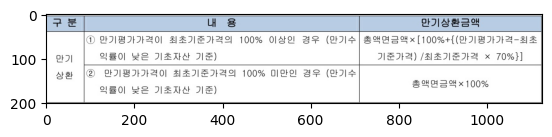

이 표는 만기 상환 조건에 따른 상환금액을 설명하는 금융상품의 구조입니다.

**주요 내용:**

1. **만기평가가격이 최초기준가격의 100% 이상인 경우:**
   - 수익률이 낮은 기초자산을 기준으로 함
   - 상환금액 = 총액면금액 × [100% + (만기평가가격-최초기준가격)/최초기준가격 × 70%]
   - 즉, 원금 보장 + 상승분의 70% 수익 참여

2. **만기평가가격이 최초기준가격의 100% 미만인 경우:**
   - 수익률이 낮은 기초자산을 기준으로 함
   - 상환금액 = 총액면금액 × 100%
   - 즉, 원금만 상환 (손실 발생 시에도 원금 보장)

이는 원금보장형 파생결합증권(DLS)의 전형적인 구조로, 하락 시 원금을 보장하고 상승 시 일정 비율의 수익을 제공하는 상품입니다.


metadata:
 {'origin_table': '| 구 분 | 내 용 | 만기상환금액 |\n| --- | --- | --- |\n| 만기 상환 | ① 만기평가가격이 최초기준가격의 100% 이상인
경우 (만기수 익률이 낮은 기초자산 기준) | 총액면금액×[100%+{(만기평가가격-최초 기준가격) /최초기준가격 × 70%}] |\n| 만기 상환 | ② 만기평가가격이
최초기준가격의 100% 미만인 경우 (만기수 익률이 낮은 기초자산 기준) | 총액면금액×100% |\n', 'text_as_html': '| 구 분 | 내 용 | 만기상환금액
|\n| --- | --- | --- |\n| 만기 상환 | ① 만기평가가격이 최초기준가격의 100% 이상인 경우 (만기수 익률이 낮은 기초자산 기준) |
총액면금액×[100%+{(만기평가가격-최초 기준가격) /최초기준가격 × 70%}] |\n| 만기 상환 | ② 만기평가가격이 최초기준가격의 100% 미만인 경우 (만기수 익률이 낮은
기초자산 기준) | 총액면금액×100% |\n', 'category': 'Table', 'image_base64': '', 'family_tree': 'parent_table',
'parent_id': 'NA', 'id': '66442a6d-7f0b-4dc2-b2f4-ab1f380980cd', 'origin_image': '',
'orig_elements': ''}

-----------------------------------------------
3. Category: Image, Chunk: 812 Characters
-----------------------------------------------


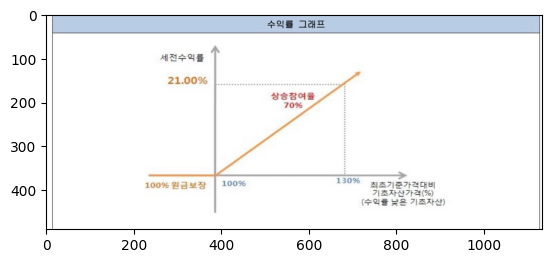

주어진 이미지와 contexts를 분석한 결과는 다음과 같습니다:

## <title>
수익률 그래프 - 금융상품 손익구조

## <summary>
이 그래프는 금융상품의 손익구조를 보여주는 것으로, 기초자산 가격 변동에 따른 세전 수익률을 나타냅니다. X축은 최초기준가격 대비 기초자산 가격 변동률(100%~130%)을,
Y축은 세전 수익률(최대 21.00%)을 표시합니다. 상승참여율 70%가 적용되어 기초자산이 상승할 때 일정 비율로 수익에 참여하는 구조를 보여줍니다.

## <entities>
- **세전수익률**: 세금을 제하기 전의 투자 수익률로, 최대 21.00%까지 가능
- **기초자산가격**: KOSPI200과 금가격지수가 기초자산으로 사용됨
- **상승참여율 70%**: 기초자산이 상승할 때 실제 수익률에 70%만 반영되는 비율
- **100% 원금보장**: 기초자산 가격이 하락해도 원금은 보장되는 구조
- **최초기준가격결정일**: KOSPI200 250pt, 금가격지수 $1,500를 기준으로 설정
- **만기평가일**: 상품 만료 시점에서 손익을 결정하는 날짜

## <hypothetical_questions>
1. 기초자산이 130% 상승했을 때 실제 수익률은 얼마가 될까요?
2. KOSPI200이 20% 상승하고 금가격이 10% 하락한 경우의 수익률은?
3. 원금보장 조건이 어떤 상황에서 적용되는가?
4. 상승참여율 70%의 의미와 실제 수익 계산 방법은?
5. 1억원 투자 시 최대 수익금은 얼마인가?

이 상품은 원금을 보장하면서도 기초자산 상승 시 제한적이지만 수익 참여가 가능한 구조화 상품으로 보입니다.
metadata:
 {'markdown': '![image](/image/placeholder)\n수익률 그래프 \n', 'category': 'Image', 'image_base64': '',
'family_tree': 'parent_image', 'parent_id': 'NA', 'id': '6ff42ade-dd74-4363-94

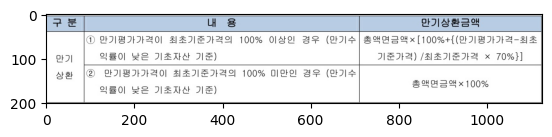

주어진 이미지를 분석한 결과, 이는 파생결합증권(DLS)의 만기상환 조건을 설명하는 표입니다.

## <title>
미래에셋증권 제253회 파생결합증권(DLS) 만기상환 조건표

## <summary>
이 표는 원금보장형 DLS 상품의 만기상환 조건을 두 가지 시나리오로 구분하여 설명합니다. 만기평가가격이 최초기준가격의 100% 이상인지 미만인지에 따라 상환금액이 달라지며,
100% 미만인 경우에도 원금이 보장됩니다.

## <entities>
1. **만기평가가격**: 만기일(2012년 7월 3일)의 기초자산 종가로 결정되는 가격
2. **최초기준가격**: 2011년 7월 7일의 기초자산 종가로 결정되는 기준 가격
3. **만기상환금액**: 투자자가 만기에 받게 되는 최종 상환금액
4. **총액면금액**: 투자자가 최초에 투자한 원금
5. **기초자산**: KOSPI200 지수와 금가격지수 두 개의 기초자산
6. **70% 참여율**: 수익률 계산 시 적용되는 참여 비율

## <hypothetical_questions>
1. 두 기초자산 모두 최초기준가격 대비 상승했을 때 수익률은 어떻게 계산되는가?
2. 한 기초자산은 상승하고 다른 기초자산은 하락했을 때 어떤 기준으로 수익률이 결정되는가?
3. 두 기초자산 모두 최초기준가격보다 하락했을 때도 원금이 보장되는가?
4. 참여율 70%가 최종 수익률에 미치는 영향은 무엇인가?
5. 만기평가가격이 정확히 최초기준가격과 같을 때는 어떤 조건이 적용되는가?

이 상품은 원금보장형 구조로 설계되어 있어, 기초자산의 성과가 좋지 않더라도 투자원금은 보장받을 수 있는 특징을 가지고 있습니다.
metadata:
 {'markdown': '| 구 분 | 내 용 | 만기상환금액 |\n| --- | --- | --- |\n| 만기 상환 | ① 만기평가가격이 최초기준가격의 100% 이상인 경우
(만기수 익률이 낮은 기초자산 기준) | 총액면금액×[100%+{(만기평가가격-최초 기준가격) /최초기준가격 × 70%}] |\n| 만기

In [90]:
show_context_used(search_hybrid_result)

### RAG

In [91]:
from textwrap import dedent

In [92]:
system_prompt = dedent(
    """
    You are a master answer bot designed to answer user's questions.
    I'm going to give you contexts which consist of texts, tables and images.
    Read the contexts carefully, because I'm going to ask you a question about it.
    """
)

human_prompt = dedent(
    """
    Here is the contexts as texts: <contexts>{contexts}</contexts>

    First, find a few paragraphs or sentences from the contexts that are most relevant to answering the question.
    Then, answer the question as much as you can.

    Skip the preamble and go straight into the answer.
    Don't insert any XML tag such as <contexts> and </contexts> when answering.
    Answer in Korean.

    Here is the question: <question>{question}</question>

    If the question cannot be answered by the contexts, say "No relevant contexts".
    """
)

In [93]:
qa = rag_chain(
    llm_text=llm_text,
    retriever=opensearch_hybrid_retriever,
    system_prompt=system_prompt,
    human_prompt=human_prompt,
    return_context=True,
    verbose=False,
)

In [94]:
query = "만기 상환금액에 대해서 알려줘"

response, contexts = qa.invoke(
    query = query
)

verbose False
문서에서 만기 상환금액에 대한 관련 내용을 찾겠습니다.

**만기 상환금액 관련 내용:**

만기 상환금액은 두 가지 경우로 구분됩니다:

**① 만기평가가격이 최초기준가격의 100% 이상인 경우 (만기수익률이 낮은 기초자산 기준)**
- 만기상환금액 = 총액면금액×[100%+{(만기평가가격-최초기준가격)/최초기준가격 × 70%}]

**② 만기평가가격이 최초기준가격의 100% 미만인 경우 (만기수익률이 낮은 기초자산 기준)**
- 만기상환금액 = 총액면금액×100%

**구체적인 계산 사례 (1억원 투자 기준):**

- **만기상환 ①**: 두 기초자산의 만기평가가격이 KOSPI200은 300pt, 금가격지수는 $1,650인 경우
  ⇒ 1억원 700만원 지급 = 1억원×[100%+{(1,650-1,500)/1,500×70%}] (만기수익률이 낮은 금가격지수 기준)

- **만기상환 ②**: 두 기초자산의 만기평가가격이 KOSPI200은 300pt, 금가격지수는 $1,350인 경우
  ⇒ 1억원 지급(100% 원금보장)

**핵심 특징:**
- 본 상품은 원금보장형으로, 기초자산이 하락하더라도 원금은 100% 보장됩니다
- 기초자산이 상승할 경우 상승분의 70%만큼 추가 수익을 받을 수 있습니다
- 두 기초자산(KOSPI200 지수, 금가격지수) 중 수익률이 낮은 기초자산을 기준으로 계산합니다


-----------------------------------------------
1. Chunk: 981 Characters
-----------------------------------------------
핵 심 설 명 서

이 설명서는 금융소비자의 권익 보호 및 금융상품에 대한 이해 증진을 위하여
금융상품의 핵심내용을 쉽게 이해하실 수 있도록 작성한 것입니다. 상품내용을
충분히 이해하신 다음에 청약여부를 결정하시기 바랍니다.

# 핵심설명서

# [미래에셋증권 제 253 회 파생결합증권(DLS)(원금보장형)]

# 1

# 상품 개요

- ○ 모집가액: 100 억원 (모집된 금액이 10 억 미만일 경우 발행이 취소될 수 있음)
- ○ 기초자산: KOSPI200 지수(블룸버그 Ticker: KOSPI2 index),
- 금가격지수 (블룸버그 Ticker: GOLDLNPM index)
- ○ 청약기간 : 2011 년 07 월 04 일 ~2011 년 07 월 07 일 16 시
- ○ 청약단위 : 100 만원 이상 100 만원 단위 (발행 후 추가 납입 불가)
- ○ 발 행 일 : 2011 년 07 월 08 일
- ○ 만 기 일 : 2012 년 07 월 09 일(만기 1 년)
- ○ 상품위험등급: 4 등급


# 2

# 기준가격 결정일 및 평가방법

- ○ 최초 기준가격: 2011 년 07 월 07 일의 종가(해당 거래소 기준)
- ○ 만기 평가가격: 2012 년 07 월 03 일의 종가(해당 거래소 기준)


# 3 손익 구조

| 구 분 | 내 용 | 만기상환금액 |
| --- | --- | --- |
| 만기 상환 | ① 만기평가가격이 최초기준가격의 100% 이상인 경우 (만기수 익률이 낮은 기초자산 기준) | 총액면금액×[100%+{(만기평가가격-최초 기준가격) /최초기준가격
× 70%}] |
| 만기 상환 | ② 만기평가가격이 최초기준가격의 100% 미만인 경우 (만기수 익률이 낮은 기초자산 기준) | 총액면금액×100% |


※ 만기수익률

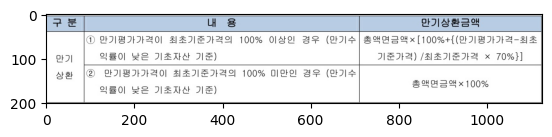

이 표는 만기 상환 조건에 따른 상환금액을 설명하는 금융상품의 구조입니다.

**주요 내용:**

1. **만기평가가격이 최초기준가격의 100% 이상인 경우:**
   - 수익률이 낮은 기초자산을 기준으로 함
   - 상환금액 = 총액면금액 × [100% + (만기평가가격-최초기준가격)/최초기준가격 × 70%]
   - 즉, 원금 보장 + 상승분의 70% 수익 참여

2. **만기평가가격이 최초기준가격의 100% 미만인 경우:**
   - 수익률이 낮은 기초자산을 기준으로 함
   - 상환금액 = 총액면금액 × 100%
   - 즉, 원금만 상환 (손실 발생 시에도 원금 보장)

이는 원금보장형 파생결합증권(DLS)의 전형적인 구조로, 하락 시 원금을 보장하고 상승 시 일정 비율의 수익을 제공하는 상품입니다.


metadata:
 {'origin_table': '| 구 분 | 내 용 | 만기상환금액 |\n| --- | --- | --- |\n| 만기 상환 | ① 만기평가가격이 최초기준가격의 100% 이상인
경우 (만기수 익률이 낮은 기초자산 기준) | 총액면금액×[100%+{(만기평가가격-최초 기준가격) /최초기준가격 × 70%}] |\n| 만기 상환 | ② 만기평가가격이
최초기준가격의 100% 미만인 경우 (만기수 익률이 낮은 기초자산 기준) | 총액면금액×100% |\n', 'text_as_html': '| 구 분 | 내 용 | 만기상환금액
|\n| --- | --- | --- |\n| 만기 상환 | ① 만기평가가격이 최초기준가격의 100% 이상인 경우 (만기수 익률이 낮은 기초자산 기준) |
총액면금액×[100%+{(만기평가가격-최초 기준가격) /최초기준가격 × 70%}] |\n| 만기 상환 | ② 만기평가가격이 최초기준가격의 100% 미만인 경우 (만기수 익률이 낮은
기초자산 기준) | 총액면금액×100% |\n', 'category': 'Table', 'image_base64': '', 'family_tree': 'parent_table',
'parent_id': 'NA', 'id': '66442a6d-7f0b-4dc2-b2f4-ab1f380980cd', 'origin_image': '',
'orig_elements': ''}

-----------------------------------------------
3. Category: Image, Chunk: 813 Characters
-----------------------------------------------


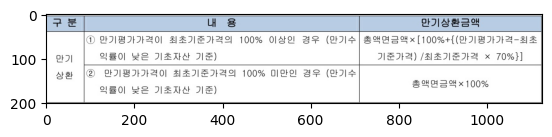

주어진 이미지를 분석한 결과, 이는 파생결합증권(DLS)의 만기상환 조건을 설명하는 표입니다.

## <title>
미래에셋증권 제253회 파생결합증권(DLS) 만기상환 조건표

## <summary>
이 표는 원금보장형 DLS 상품의 만기상환 조건을 두 가지 시나리오로 구분하여 설명합니다. 만기평가가격이 최초기준가격의 100% 이상인지 미만인지에 따라 상환금액이 달라지며,
100% 미만인 경우에도 원금이 보장됩니다.

## <entities>
1. **만기평가가격**: 만기일(2012년 7월 3일)의 기초자산 종가로 결정되는 가격
2. **최초기준가격**: 2011년 7월 7일의 기초자산 종가로 결정되는 기준 가격
3. **만기상환금액**: 투자자가 만기에 받게 되는 최종 상환금액
4. **총액면금액**: 투자자가 최초에 투자한 원금
5. **기초자산**: KOSPI200 지수와 금가격지수 두 개의 기초자산
6. **70% 참여율**: 수익률 계산 시 적용되는 참여 비율

## <hypothetical_questions>
1. 두 기초자산 모두 최초기준가격 대비 상승했을 때 수익률은 어떻게 계산되는가?
2. 한 기초자산은 상승하고 다른 기초자산은 하락했을 때 어떤 기준으로 수익률이 결정되는가?
3. 두 기초자산 모두 최초기준가격보다 하락했을 때도 원금이 보장되는가?
4. 참여율 70%가 최종 수익률에 미치는 영향은 무엇인가?
5. 만기평가가격이 정확히 최초기준가격과 같을 때는 어떤 조건이 적용되는가?

이 상품은 원금보장형 구조로 설계되어 있어, 기초자산의 성과가 좋지 않더라도 투자원금은 보장받을 수 있는 특징을 가지고 있습니다.
metadata:
 {'markdown': '| 구 분 | 내 용 | 만기상환금액 |\n| --- | --- | --- |\n| 만기 상환 | ① 만기평가가격이 최초기준가격의 100% 이상인 경우
(만기수 익률이 낮은 기초자산 기준) | 총액면금액×[100%+{(만기평가가격-최초 기준가격) /최초기준가격 × 70%}] |\n| 만기

In [95]:
show_context_used(contexts)

# SageMaker Processing Job 이용하기

## 1. scripy 만들기

In [ ]:
%%writefile ./src/preprocessing.py

import os
import json
import copy
import boto3
import shutil
import argparse
from pprint import pprint
from utils import bedrock
from itertools import chain
from utils.bedrock import bedrock_info

from langchain_aws import ChatBedrock
from langchain_aws import BedrockEmbeddings
from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler

import math
import base64
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
from langchain_core.documents import Document
from pdf2image import convert_from_path
from requests_toolbelt import MultipartEncoder

import botocore
from utils.common_utils import retry
from langchain.schema.output_parser import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate, HumanMessagePromptTemplate, SystemMessagePromptTemplate

from utils.chunk import parant_documents
from utils.opensearch import opensearch_utils
from langchain_community.vectorstores import OpenSearchVectorSearch

class preprocess():
    
    def __init__(self, args):
        
        self.args = args
        self.proc_prefix = self.args.proc_prefix #'/opt/ml/processing'
        
        self.input_dir = os.path.join(self.proc_prefix, "input")
        self.output_dir = os.path.join(self.proc_prefix, "output")
        os.makedirs(self.input_dir, exist_ok=True)
        os.makedirs(self.output_dir, exist_ok=True)
        
        print (os.listdir(self.input_dir))
        
        ############# 수정
        #self.file_path = os.path.join(self.input_dir, "sample-2.pdf")
        self.file_path = os.path.join(self.input_dir, self.args.file_name)
        #"./data/complex_pdf/sample-2.pdf"
        ###############
        
    def _initialization(self, ):
        
        self.boto3_bedrock = bedrock.get_bedrock_client(
            assumed_role=os.environ.get("BEDROCK_ASSUME_ROLE", None),
            endpoint_url=os.environ.get("BEDROCK_ENDPOINT_URL", None),
            region=os.environ.get("AWS_DEFAULT_REGION", None),
        )
        
        self.llm_text = ChatBedrock(
            model_id=bedrock_info.get_model_id(model_name="Claude-V3-5-Sonnet"),
            client=self.boto3_bedrock,
            streaming=True,
            callbacks=[StreamingStdOutCallbackHandler()],
            model_kwargs={
                "max_tokens": 2048,
                "stop_sequences": ["\n\nHuman"],
            }
        )
        
        self.llm_emb = BedrockEmbeddings(
            client=self.boto3_bedrock,
            model_id=bedrock_info.get_model_id(model_name="Titan-Text-Embeddings-V2")
        )
        self.dimension = 1024
        
    def _document_parsing(self, ):
        
        runtime_sm_client = boto3.client('runtime.sagemaker')

        # Prepare multipart form data
        encoder = MultipartEncoder(
            fields={
                'document': (os.path.basename(self.file_path), open(self.file_path, 'rb'), 'application/pdf'),
                'model': 'document-parse',
                'ocr': 'auto',
                'coordinates': 'true',
                'output_formats': '["markdown"]', #'["text", "html", "markdown"]',
                'base64_encoding': '["table", "figure"]'
            }
        )

        # Get the raw bytes of the multipart form data
        body = encoder.to_string()

        response = runtime_sm_client.invoke_endpoint(
            EndpointName=self.args.endpoint_document_parser,
            ContentType=encoder.content_type,  # This will be 'multipart/form-data; boundary=...'
            Body=body
        )

        result = response["Body"].read()
        parse_output = json.loads(result)
        
        return parse_output
    
    def _extract_image_table(self, parse_output):
        
        def processing(**kwargs):
    
            category = kwargs["category"]
            markdown = kwargs["markdown"]
            base64_encoding = kwargs["base64_encoding"]
            coordinates = kwargs["coordinates"]
            page = kwargs["page"]
            docs = kwargs["docs"]

            if page in docs: 
                docs[page].append(
                    {
                        "category": category,
                         "markdown": markdown,
                         "base64_encoding": base64_encoding,
                         "coordinates": coordinates
                    }
                )
            else:
                docs[page] = [
                    {
                        "category": category,
                        "markdown": markdown,
                        "base64_encoding": base64_encoding,
                        "coordinates": coordinates
                    }
                ]

            return docs

        def image_conversion(**kwargs):

            image_path = kwargs["image_path"]
            file_path = kwargs["file_path"]

            image_tmp_path = os.path.join(image_path, "tmp")
            if os.path.isdir(image_tmp_path): shutil.rmtree(image_tmp_path)
            os.mkdir(image_tmp_path)

            # from pdf to image
            pages = convert_from_path(file_path)
            for i, page in enumerate(pages):
                print (f'pdf page {i}, size: {page.size}')    
                page.save(f'{image_tmp_path}/{str(i+1)}.jpg', "JPEG")

            return image_tmp_path
        
        image_path = os.path.join(self.input_dir, "fig")
        if os.path.isdir(image_path): shutil.rmtree(image_path)
        os.mkdir(image_path)
        
        docs = {}
        texts = [
            Document(
                page_content=parse_output["content"]["markdown"]
            )
        ]

        ## extract_image_table
        image_tmp_path = image_conversion(
            image_path=image_path,
            file_path=self.file_path
        )

        for idx, value in enumerate(parse_output["elements"]):

            category = value["category"]
            markdown = value["content"]["markdown"]
            page = value["page"]

            if category in ["figure", "table"]:

                base64_encoding = value["base64_encoding"]    
                coordinates = value["coordinates"]    
                img = Image.open(BytesIO(base64.b64decode(base64_encoding)))
                plt.imshow(img)
                plt.show()

                page_img = Image.open(f'{image_tmp_path}/{page}.jpg')
                w, h = page_img.size  # PIL은 (width, height) 순서

                # 좌표 계산
                left = math.ceil(coordinates[0]["x"] * w)
                top = math.ceil(coordinates[0]["y"] * h)
                right = math.ceil(coordinates[1]["x"] * w)
                bottom = math.ceil(coordinates[3]["y"] * h)

                # PIL로 이미지 크롭
                crop_img = page_img.crop((left, top, right, bottom))
                        
                crob_image_path = f'{image_path}/element-{idx}.jpg'
                crop_img.save(crob_image_path)

                w_crop, h_crop = crop_img.size
                image_token = w_crop*h_crop/750
                print (f'image: {crob_image_path}, shape: ({w_crop}, {h_crop}), image_token_for_claude3: {image_token}' )
                
            else:
                base64_encoding= ""
                coordinates=""

            docs = processing(
                docs=docs,
                page=page,
                category=category,
                markdown=markdown,
                base64_encoding=base64_encoding,
                coordinates=coordinates
            )
            
        return docs, texts
    
    def _context_generation_for_image(self, docs):
        
        def manipulate_docs_for_summary(docs):
            
            docs_for_summary = []
            for page, elements in docs.items():

                elements = [element for element in elements if element["category"] != "footer"]
                print (f'page: {page}, # elements: {len(elements)}')

                for idx, element in enumerate(elements):

                    category, markdown = element["category"], element["markdown"]
                    print (f'element idx: {idx}, category: {element["category"]}')

                    elements_copy = copy.deepcopy(elements)
                    if category in ("figure", "table"):  
                        
                        summary_target = elements_copy.pop(idx)
                        contexts_markdown = '\n'.join([context["markdown"] for context in elements_copy])
                        docs_for_summary.append(
                            {
                                "target_category": summary_target["category"],
                                "target_base64": summary_target["base64_encoding"],
                                "target_markdown": summary_target["markdown"],
                                "contexts_markdown": contexts_markdown
                            }
                        )
                
            return docs_for_summary
        
        def get_summary_chain():
            
            system_prompt = "You are an assistant tasked with describing table and image."
            system_message_template = SystemMessagePromptTemplate.from_template(system_prompt)

            human_prompt = [
                {
                    "type": "image_url",
                    "image_url": {
                        "url": "data:image/png;base64," + "{image_base64}",
                    },
                },
                {
                    "type": "text",
                    "text": '''
                             <contexts>
                             {contexts}
                             </contexts>

                             주어진 이미지 또는 테이블을 자세히 분석하고 주어진 contexts를 참고하여 다음 정보를 추출해주세요:

                             1. <title> 태그 안의 제목을 정확히 제시해주세요.
                             2. <summary> 태그 안의 내용을 요약해주세요.
                             3. <entities> 태그 안의 모든 항목을 나열하고, 각 항목에 대한 간단한 설명을 제공해주세요.
                             4. <hypothetical_questions> 태그 안의 질문들을 모두 나열해주세요.
                            모든 정보는 원본 내용을 정확히 반영하되, 필요한 경우 약간의 추가 설명을 덧붙여 이해를 돕도록 해주세요.
                    '''
                },
            ]
            human_message_template = HumanMessagePromptTemplate.from_template(human_prompt)
            
            prompt = ChatPromptTemplate.from_messages(
                [
                    system_message_template,
                    human_message_template
                ]
            )

            summarize_chain = prompt | self.llm_text | StrOutputParser()
            
            return summarize_chain
        
        @retry(total_try_cnt=5, sleep_in_sec=10, retryable_exceptions=(botocore.exceptions.EventStreamError))
        def summary_img(summarize_chain, image_base64, contexts):

            img = Image.open(BytesIO(base64.b64decode(image_base64)))
            plt.imshow(img)
            plt.show()

            stream = summarize_chain.stream(
                {
                    "image_base64": image_base64,
                    "contexts": contexts
                }
            )
            response = ""
            for chunk in stream: response += chunk

            return response
            
        docs_for_summary = manipulate_docs_for_summary(docs)
        
        print ("docs_for_summary", len(docs_for_summary))
        
        
        summarize_chain = get_summary_chain()
        
        summaries = []
        for idx, doc in enumerate(docs_for_summary):
            summary = summary_img(summarize_chain, doc["target_base64"], doc["contexts_markdown"])
            summaries.append(summary)
            print ("\n==")
            print (idx)
            
        images_preprocessed = []
        for doc, summary in zip(docs_for_summary, summaries):

            metadata = {}
            metadata["markdown"] = doc["target_markdown"]
            metadata["category"] = "Image"
            metadata["image_base64"] = doc["target_base64"]

            doc = Document(
                page_content=summary,
                metadata=metadata
            )
            images_preprocessed.append(doc)
            
        for image in images_preprocessed:
            image.metadata["family_tree"], image.metadata["parent_id"] = "parent_image", "NA"
        
        return images_preprocessed, docs_for_summary

    def _context_generation_for_table(self, docs_for_summary):
        
        def get_summary_chain():
            
            system_prompt = "You are an assistant tasked with describing table and image."
            system_message_template = SystemMessagePromptTemplate.from_template(system_prompt)
            
            human_prompt = [
                {
                    "type": "text",
                    "text": '''
                             Here is the table: <table>{table}</table>
                             Given table, give a concise summary.
                             Don't insert any XML tag such as <table> and </table> when answering.
                             Write in Korean.
                    '''
                },
            ]
            human_message_template = HumanMessagePromptTemplate.from_template(human_prompt)

            prompt = ChatPromptTemplate.from_messages(
                [
                    system_message_template,
                    human_message_template
                ]
            )

            summarize_chain = {"table": lambda x:x} | prompt | self.llm_text | StrOutputParser()
            
            return summarize_chain
        
        tables = [doc for doc in docs_for_summary if doc["target_category"] == "table"]
        summarize_chain = get_summary_chain()
        table_info = [t["target_markdown"] for t in tables]
        table_summaries = summarize_chain.batch(table_info, config={"max_concurrency": 1})
        
        tables_preprocessed = []
        for doc, summary in zip(tables, table_summaries):

            metadata = {}
            metadata["origin_table"] = doc["target_markdown"]
            metadata["text_as_html"] = doc["target_markdown"]
            metadata["category"] = "Table"
            metadata["image_base64"] = doc["target_base64"]

            doc = Document(
                page_content=summary,
                metadata=metadata
            )
            tables_preprocessed.append(doc)
        
        for table in tables_preprocessed:
            table.metadata["family_tree"], table.metadata["parent_id"] = "parent_table", "NA"
            
        return tables_preprocessed
    
    def _opensearch(self, ):
        
        index_body = {
            'settings': {
                'analysis': {
                    'analyzer': {
                        'my_analyzer': {
                                 'char_filter':['html_strip'],
                            'tokenizer': 'nori',
                            'filter': [
                                #'nori_number',
                                #'lowercase',
                                #'trim',
                                'my_nori_part_of_speech'
                            ],
                            'type': 'custom'
                        }
                    },
                    'tokenizer': {
                        'nori': {
                            'decompound_mode': 'mixed',
                            'discard_punctuation': 'true',
                            'type': 'nori_tokenizer'
                        }
                    },
                    "filter": {
                        "my_nori_part_of_speech": {
                            "type": "nori_part_of_speech",
                            "stoptags": [
                                "J", "XSV", "E", "IC","MAJ","NNB",
                                "SP", "SSC", "SSO",
                                "SC","SE","XSN","XSV",
                                "UNA","NA","VCP","VSV",
                                "VX"
                            ]
                        }
                    }
                },
                'index': {
                    'knn': True,
                    'knn.space_type': 'cosinesimil'  # Example space type
                }
            },
            'mappings': {
                'properties': {
                    'metadata': {
                        'properties': {
                            'source': {'type': 'keyword'},
                            'page_number': {'type':'long'},
                            'category': {'type':'text'},
                            'file_directory': {'type':'text'},
                            'last_modified': {'type': 'text'},
                            'type': {'type': 'keyword'},
                            'image_base64': {'type':'text'},
                            'origin_image': {'type':'text'},
                            'origin_table': {'type':'text'},
                        }
                    },
                    'text': {
                        'analyzer': 'my_analyzer',
                        'search_analyzer': 'my_analyzer',
                        'type': 'text'
                    },
                    'vector_field': {
                        'type': 'knn_vector',
                        'dimension': f"{self.dimension}" # Replace with your vector dimension
                    }
                }
            }
        }

        opensearch_domain_endpoint = self.args.opensearch_domain_endpoint
        opensearch_user_id = self.args.opensearch_user_id
        opensearch_user_password = self.args.opensearch_user_password
        index_name = self.args.index_name
        
        http_auth = (opensearch_user_id, opensearch_user_password) # Master username, Master password
        
        ## opensearch clinet 생성
        aws_region = os.environ.get("AWS_DEFAULT_REGION", None)
        os_client = opensearch_utils.create_aws_opensearch_client(
            aws_region,
            opensearch_domain_endpoint,
            http_auth
        )
        
        ## opensearch index 생성
        index_exists = opensearch_utils.check_if_index_exists(
            os_client,
            index_name
        )

        if index_exists:
            opensearch_utils.delete_index(
                os_client,
                index_name
            )

        opensearch_utils.create_index(os_client, index_name, index_body)
        index_info = os_client.indices.get(index=index_name)
        print("Index is created")
        pprint(index_info)
        
        vector_db = OpenSearchVectorSearch(
            index_name=index_name,
            opensearch_url=opensearch_domain_endpoint,
            embedding_function=self.llm_emb,
            http_auth=http_auth, # http_auth
            is_aoss=False,
            engine="faiss",
            space_type="l2",
            bulk_size=100000,
            timeout=60
        )
        
        return os_client, vector_db, index_name
        
    def _chunking_and_indexing(self, os_client, vector_db, index_name, texts, images_preprocessed, tables_preprocessed):
        
        parent_chunk_size = 4096
        parent_chunk_overlap = 0

        child_chunk_size = 1024
        child_chunk_overlap = 256

        opensearch_parent_key_name = "parent_id"
        opensearch_family_tree_key_name = "family_tree"
        
        parent_chunk_docs = parant_documents.create_parent_chunk(
            docs=texts,
            parent_id_key=opensearch_parent_key_name,
            family_tree_id_key=opensearch_family_tree_key_name,
            parent_chunk_size=parent_chunk_size,
            parent_chunk_overlap=parent_chunk_overlap
        )
        print(f'Number of parent_chunk_docs= {len(parent_chunk_docs)}')
        parent_ids = vector_db.add_documents(
            documents = parent_chunk_docs, 
            vector_field = "vector_field",
            bulk_size = 1000000
        )
        
        total_count_docs = opensearch_utils.get_count(os_client, index_name)
        print("total count docs: ", total_count_docs)
                
        # child_chunk_docs = create_child_chunk(parent_chunk_docs[0:1], parent_ids)
        child_chunk_docs = parant_documents.create_child_chunk(
            child_chunk_size=child_chunk_size,
            child_chunk_overlap=child_chunk_overlap,
            docs=parent_chunk_docs,
            parent_ids_value=parent_ids,
            parent_id_key=opensearch_parent_key_name,
            family_tree_id_key=opensearch_family_tree_key_name
        )

        print(f"Number of child_chunk_docs= {len(child_chunk_docs)}")
        parent_id = child_chunk_docs[0].metadata["parent_id"]
        print("child's parent_id: ", parent_id)
        print("\n###### Search parent in OpenSearch")
        
        
        ## Merge
        docs_preprocessed = list(chain(child_chunk_docs, tables_preprocessed, images_preprocessed))
        
        child_ids = vector_db.add_documents(
            documents=docs_preprocessed, 
            vector_field = "vector_field",
            bulk_size=1000000
        )
        print("length of child_ids: ", len(child_ids))
        
        return child_chunk_docs
        
    def execution(self, ):
        
        ## Initialization for Bedrock
        self._initialization()
        
        ## Document parsing
        parse_output = self._document_parsing()
        
        ## Context generation for images and tables
        docs, texts = self._extract_image_table(parse_output)
        images_preprocessed, docs_for_summary = self._context_generation_for_image(docs)
        tables_preprocessed = self._context_generation_for_table(docs_for_summary)
        
        ## Opensearch setting
        os_client, vector_db, index_name = self._opensearch()
        
        ## Chunking(Parent document) and indexing
        child_chunk_docs = self._chunking_and_indexing(os_client, vector_db, index_name, texts, images_preprocessed, tables_preprocessed)
        
if __name__ == "__main__":
    
    parser = argparse.ArgumentParser()
    parser.add_argument("--region", type=str, default="us-west-2")
    parser.add_argument("--proc_prefix", type=str, default="./src")
    parser.add_argument("--endpoint_document_parser", type=str, default="")
    parser.add_argument("--opensearch_domain_endpoint", type=str, default="")
    parser.add_argument("--opensearch_user_id", type=str, default="")
    parser.add_argument("--opensearch_user_password", type=str, default="")
    parser.add_argument("--index_name", type=str, default="")
    parser.add_argument("--file_name", type=str, default="")
    
    args, _ = parser.parse_known_args()

    print("Received arguments {}".format(args))
    
    os.environ['AWS_DEFAULT_REGION'] = args.region
        
    prep = preprocess(args)
    prep.execution()
    

In [ ]:
#!python ./src/preprocessing.py

## 2. parser용 이미지 생성하기
 **[중요] ECR 사용을 위해 "AmazonEC2ContainerRegistryFullAccess" policy를 role에 추가해야 합니다**

In [ ]:
import sagemaker
from utils.ecr import ecr_handler

In [ ]:
ecr = ecr_handler()
region=boto3.Session().region_name
strAccountID = boto3.client("sts").get_caller_identity().get("Account")

In [ ]:
container_uri = sagemaker.image_uris.retrieve(
    framework="sklearn", version="1.2-1", region=region
)
container_uri

In [ ]:
%%writefile ./custom-docker/Dockerfile-docparse

FROM 246618743249.dkr.ecr.us-west-2.amazonaws.com/sagemaker-scikit-learn:1.2-1-cpu-py3

RUN wget -O - https://apt.kitware.com/keys/kitware-archive-latest.asc 2>/dev/null | gpg --dearmor - | tee /usr/share/keyrings/kitware-archive-keyring.gpg >/dev/null
RUN apt-get update
RUN apt-get install -y libgl1-mesa-glx
RUN apt-get install -y libglib2.0-0
RUN apt-get install -y poppler-utils

RUN pip install -U pip
RUN pip install botocore==1.39.10
RUN pip install boto3==1.39.9
RUN pip install sagemaker==2.248.1
RUN pip install langchain==0.3.26
RUN pip install langchain_aws==0.2.29
RUN pip install langchain_community==0.3.20
RUN pip install requests_toolbelt==1.0.0
RUN pip install pdf2image==1.17.0
RUN pip install numpy==1.26.4
RUN pip install ipython==8.18.1
RUN pip install opensearch-py==3.0.0
RUN pip install matplotlib==3.9.4
RUN pip install pillow>=10.0.0

ENV PYTHONUNBUFFERED=TRUE

In [ ]:
import botocore
botocore.__version__

In [ ]:
strRepositoryName="docparse-image"  ## <-- 원하는 docker repostory 이름을 추가
strRepositoryName = strRepositoryName.lower()
strDockerFile = "Dockerfile-docparse"
strDockerDir = "./custom-docker/"
strTag = "latest"

In [ ]:
## Build
#ecr.build_docker(strDockerDir, strDockerFile, strRepositoryName, strRegionName="ap-northeast-2", strAccountId="246618743249")
ecr.build_docker(strDockerDir, strDockerFile, strRepositoryName, strRegionName="us-west-2", strAccountId="246618743249")

In [ ]:
## Upload to ECR
strEcrRepositoryUri = ecr.register_image_to_ecr(region, strAccountID, strRepositoryName, strTag)

In [ ]:
strEcrRepositoryUri = "615299776985.dkr.ecr.us-west-2.amazonaws.com/docparse-image"

## 3. 파일 업로드 to S3

In [ ]:
import sagemaker
from utils.s3 import s3_handler

In [ ]:
sagemaker_session = sagemaker.Session()
strBucketName = sagemaker_session.default_bucket() # 기본 버킷 이름 가져오기
strLocalDataPath = "./data/complex_pdf/"

In [ ]:
s3 = s3_handler()
source_dir, target_bucket, target_dir = strLocalDataPath, strBucketName, "doc_parse_data"
s3.upload_dir(source_dir, target_bucket, target_dir)

strS3DataPath = f's3://{strBucketName}/doc_parse_data'

## 3. Processing Job 실행

In [ ]:
import os
from utils.ssm import parameter_store
from sagemaker import get_execution_role
#from sagemaker.pytorch.estimator import PyTorch
from sagemaker.sklearn.estimator import SKLearn
from sagemaker.processing import ProcessingInput, ProcessingOutput, FrameworkProcessor

In [ ]:
strRegionName = boto3.Session().region_name
strAccountId = boto3.client("sts").get_caller_identity().get("Account")
strPrefix = "doc-parse"

In [ ]:
local_mode = False

#strExecutionRole = get_execution_role()
strExecutionRole = "<your sagemaker role>"
strExecutionRole = "arn:aws:iam::615299776985:role/service-role/AmazonSageMaker-ExecutionRole-20241014T132050"

if local_mode: 
    strInstanceType = 'local'
    
    import os
    from sagemaker.local import LocalSession
    
    sagemaker_session = LocalSession()
    strDataPath = str(os.path.join("file://", os.getcwd(), "data", "complex_pdf"))
    
else:
    strInstanceType = "ml.m5.xlarge"
    sagemaker_session = sagemaker.Session()
    strDataPath = strS3DataPath
        
print (f"instance-type: {strInstanceType}")
print (f'role: {strExecutionRole}')
print (f"bucket: {strBucketName}")
print (f"dataset-path: {strDataPath}")
print (f"sagemaker_session: {sagemaker_session}")

In [ ]:
dataset_processor = FrameworkProcessor(
    estimator_cls=SKLearn,
    framework_version="1.2-1",
    py_version="py3",
    image_uri="615299776985.dkr.ecr.us-west-2.amazonaws.com/docparse-image",#"<your image uri>"
    instance_type=strInstanceType,
    instance_count=1,
    role=strExecutionRole,
    base_job_name="preprocessing", # bucket에 보이는 이름 (pipeline으로 묶으면 pipeline에서 정의한 이름으로 bucket에 보임)
    sagemaker_session=sagemaker_session
)

strProcPrefix = "/opt/ml/processing"
strOutputPath = os.path.join(
    "s3://{}".format(strBucketName),
    strPrefix,
    "preprocessing",
    "output"
)

pm = parameter_store(strRegionName)
endpoint_document_parser = "<endpoint-name>"
endpoint_document_parser = "Upstage-Document-Parse-2025-07-22-06-56-52-438"

opensearch_domain_endpoint = pm.get_params(
    key="opensearch_domain_endpoint",
    enc=False
)
opensearch_user_id = pm.get_params(
    key="opensearch_user_id",
    enc=False
)
opensearch_user_password = pm.get_params(
    key="opensearch_user_password",
    enc=True
)
index_name = "sm_prep_job"
file_name = "sample-2.pdf"

In [ ]:
dataset_processor.run(
    #job_name="preprocessing", ## 이걸 넣어야 캐시가 작동함, 안그러면 프로세서의 base_job_name 이름뒤에 날짜 시간이 붙어서 캐시 동작 안함
    #git_config=git_config,
    code='preprocessing.py', #소스 디렉토리 안에서 파일 path
    source_dir= "./src", #현재 파일에서 소스 디렉토리 상대경로 # add processing.py and requirements.txt here
    inputs=[
        ProcessingInput(
            input_name="input-data",
            source=strDataPath,
            destination=os.path.join(strProcPrefix, "input")
        ),
    ],
    outputs=[       
        ProcessingOutput(
            output_name="output-data",
            source=os.path.join(strProcPrefix, "output"),
            destination=strOutputPath
        ),
    ],
    arguments=[
        "--proc_prefix", strProcPrefix, \
        "--region", region, \
        "--endpoint_document_parser", endpoint_document_parser, \
        "--opensearch_domain_endpoint", opensearch_domain_endpoint, \
        "--opensearch_user_id", opensearch_user_id, \
        "--opensearch_user_password", opensearch_user_password, \
        "--index_name", index_name, \
        "--file_name", file_name
    ]
)


## 확인하기

In [ ]:
opensearch_hybrid_retriever = OpenSearchHybridSearchRetriever(
    os_client=os_client,
    index_name="sm_prep_job",
    llm_text=llm_text, # llm for query augmentation in both rag_fusion and HyDE
    llm_emb=llm_emb, # Used in semantic search based on opensearch 

    # hybird-search debugger
    #hybrid_search_debugger = "semantic", #[semantic, lexical, None]
    
    # option for lexical
    minimum_should_match=0,
    filter=[],

    # option for search
    fusion_algorithm="RRF", # ["RRF", "simple_weighted"], rank fusion 방식 정의
    ensemble_weights=[.51, .49], # [for semantic, for lexical], Semantic, Lexical search 결과에 대한 최종 반영 비율 정의
    reranker=True, # enable reranker with reranker model
    reranker_endpoint_name = "cohere-reranker-3-5", # endpoint name for reranking model
    parent_document=True, # enable parent document
    
    # option for complex pdf consisting of text, table and image
    complex_doc=True,
    
    # option for async search
    async_mode=True,

    # option for output
    k=7, # 최종 Document 수 정의
    verbose=True,

)

In [ ]:
%%time
query = "조기상환 여부에 따른 투자 수익률"
search_hybrid_result, tables, images = opensearch_hybrid_retriever.invoke(query)

In [ ]:
show_context_used(search_hybrid_result)